<a href="https://colab.research.google.com/github/jaympatel481/Markov-Chain-Simulation-for-Mutational-Signatures/blob/main/Markov_Chain_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

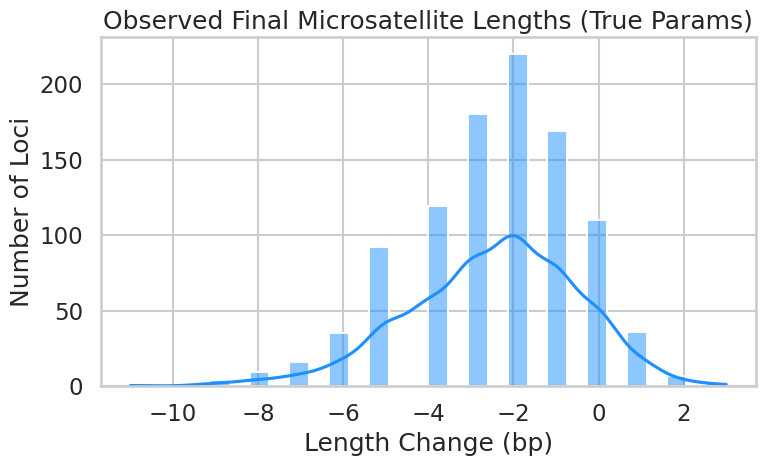

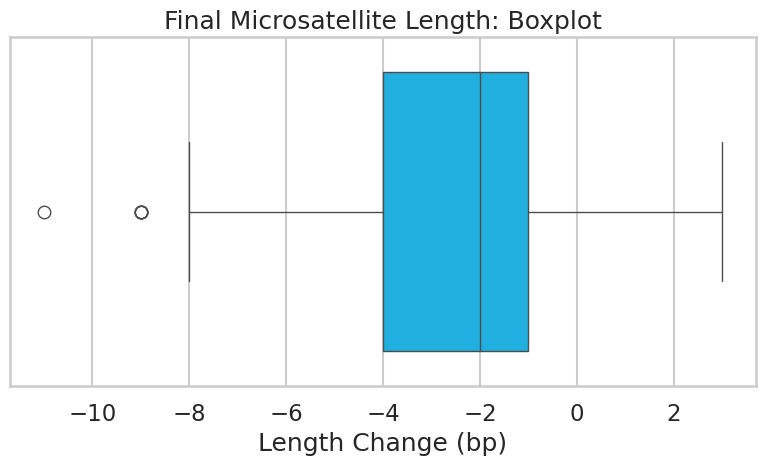

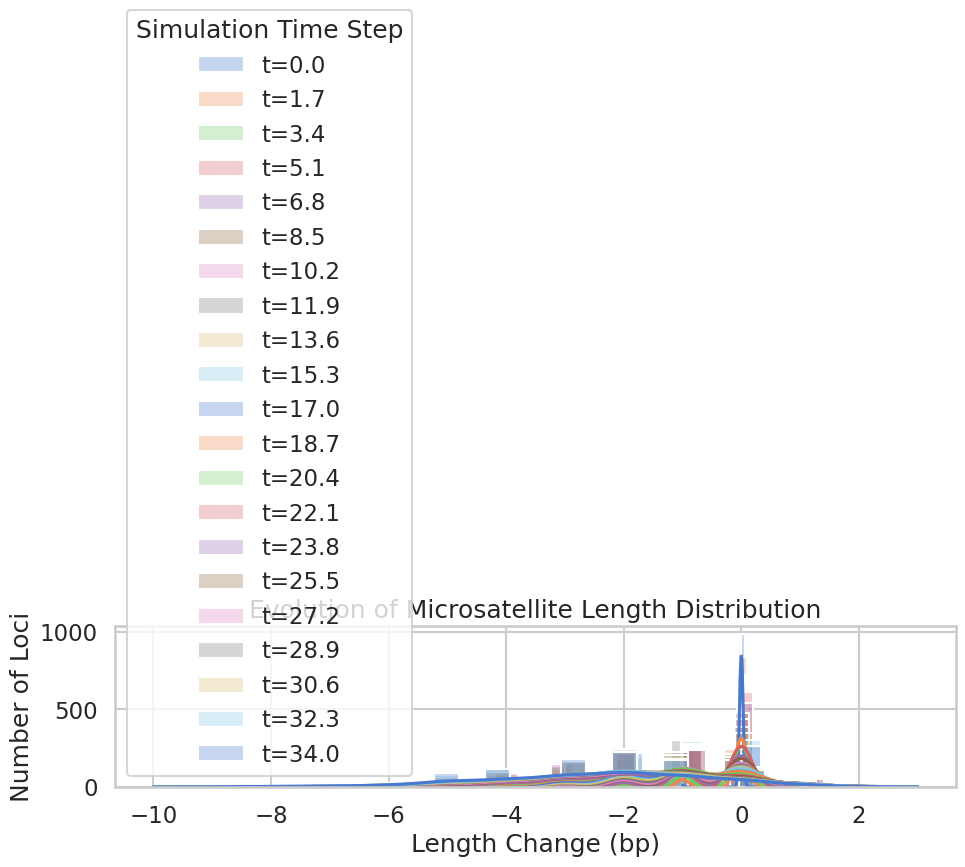

100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


Iter 1: ε=1.2047, Survived 500
μ_i: 0.02283 ± 0.01423
μ_d: 0.06557 ± 0.02342



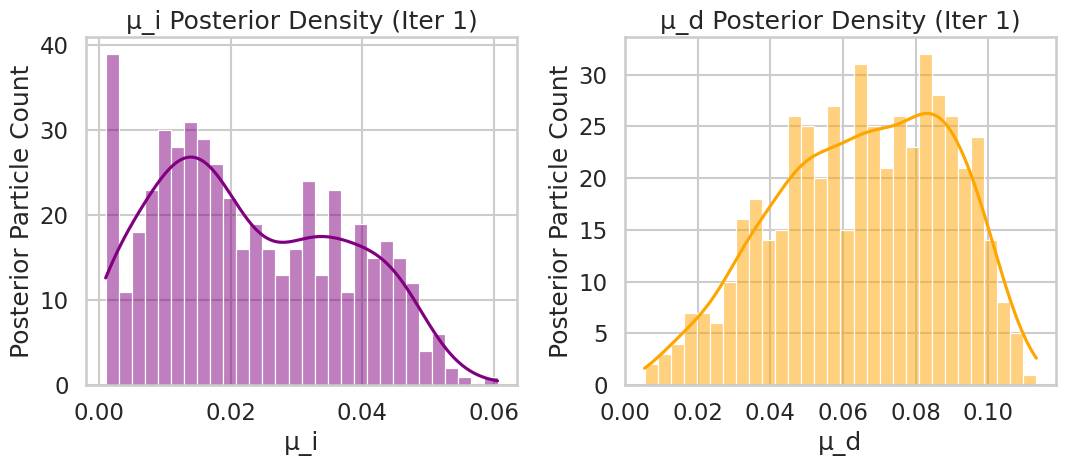

100%|██████████| 500/500 [02:05<00:00,  4.00it/s]


Iter 2: ε=0.5760, Survived 349
μ_i: 0.02199 ± 0.01416
μ_d: 0.06862 ± 0.01686



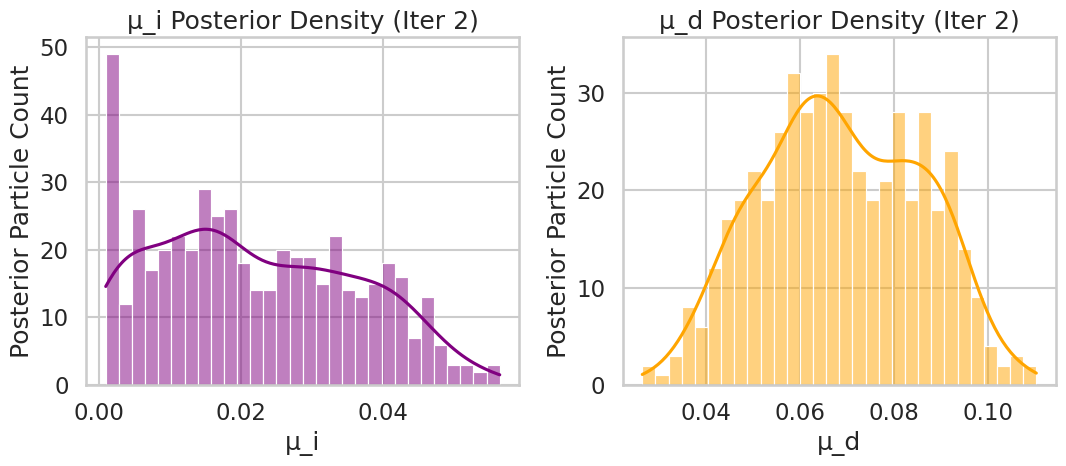

100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Iter 3: ε=0.3519, Survived 281
μ_i: 0.01847 ± 0.01221
μ_d: 0.06641 ± 0.01290



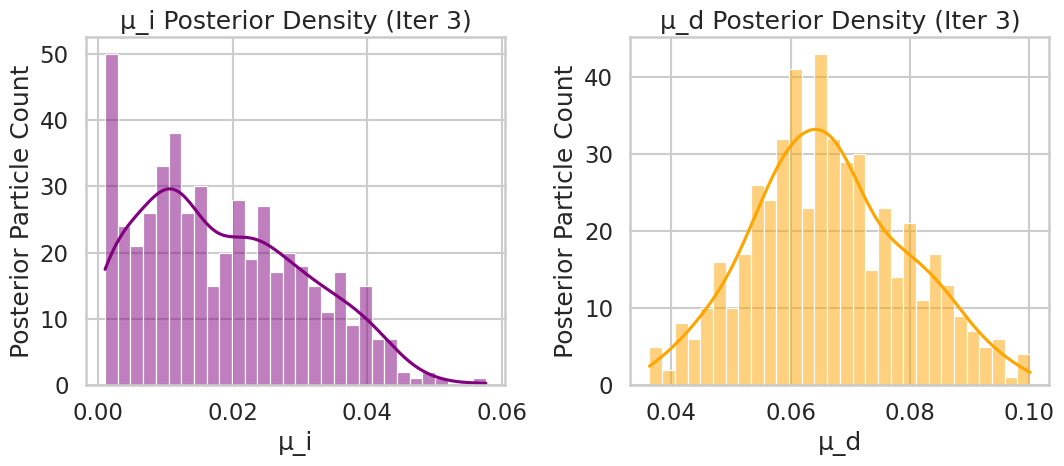

100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Iter 4: ε=0.2142, Survived 206
μ_i: 0.01400 ± 0.00861
μ_d: 0.06303 ± 0.00840



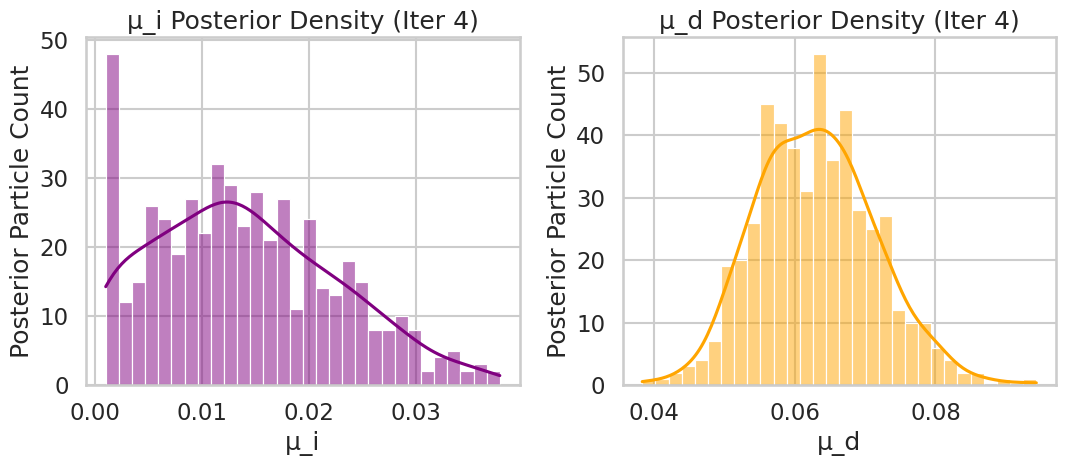

100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


Iter 5: ε=0.1368, Survived 132
μ_i: 0.01426 ± 0.00689
μ_d: 0.06270 ± 0.00686



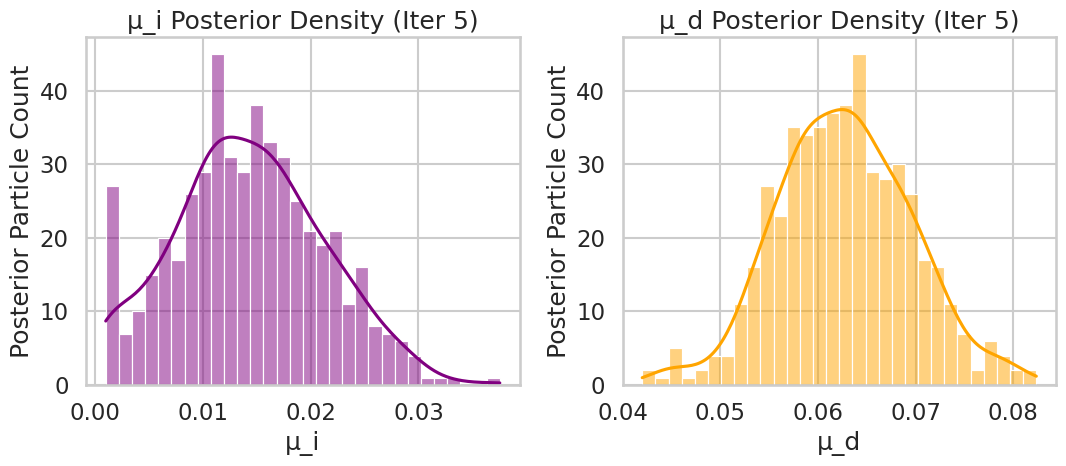

100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


Iter 6: ε=0.0918, Survived 73
μ_i: 0.01331 ± 0.00567
μ_d: 0.06306 ± 0.00621



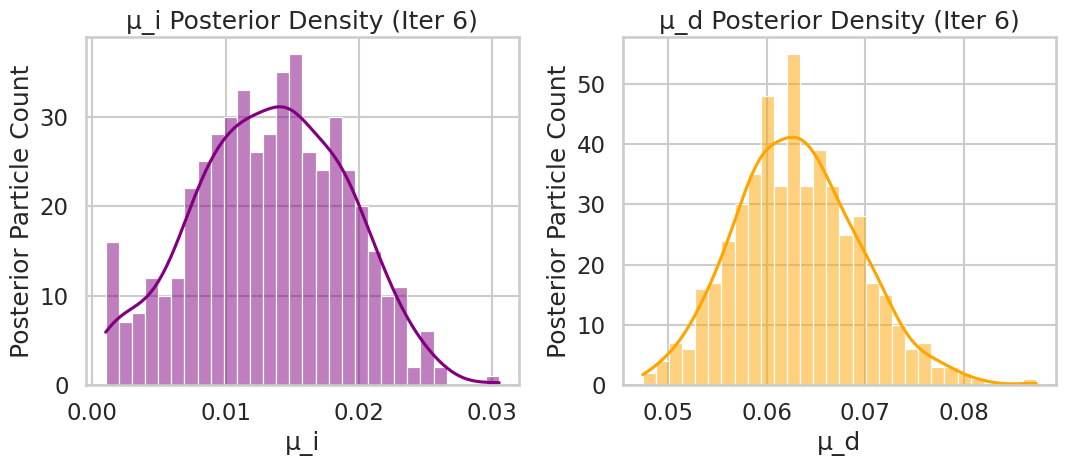

100%|██████████| 500/500 [02:05<00:00,  3.97it/s]


Iter 7: ε=0.0684, Survived 29
μ_i: 0.01359 ± 0.00529
μ_d: 0.06272 ± 0.00524



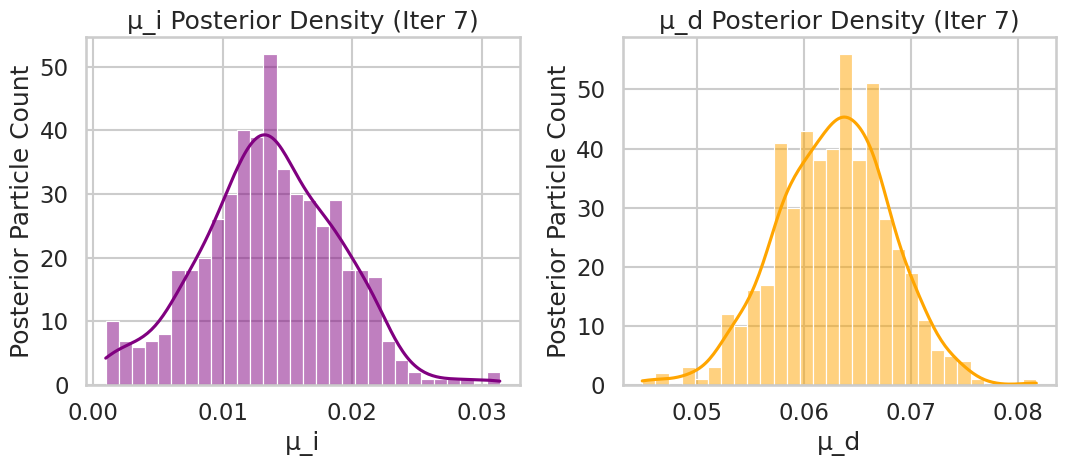

100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Reset particles at iteration 8


100%|██████████| 500/500 [02:05<00:00,  3.99it/s]


Reset particles at iteration 9


100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


Reset particles at iteration 10

True parameters: mu_i=0.015, mu_d=0.085
Estimated parameters: mu_i=0.02572, mu_d=0.05638


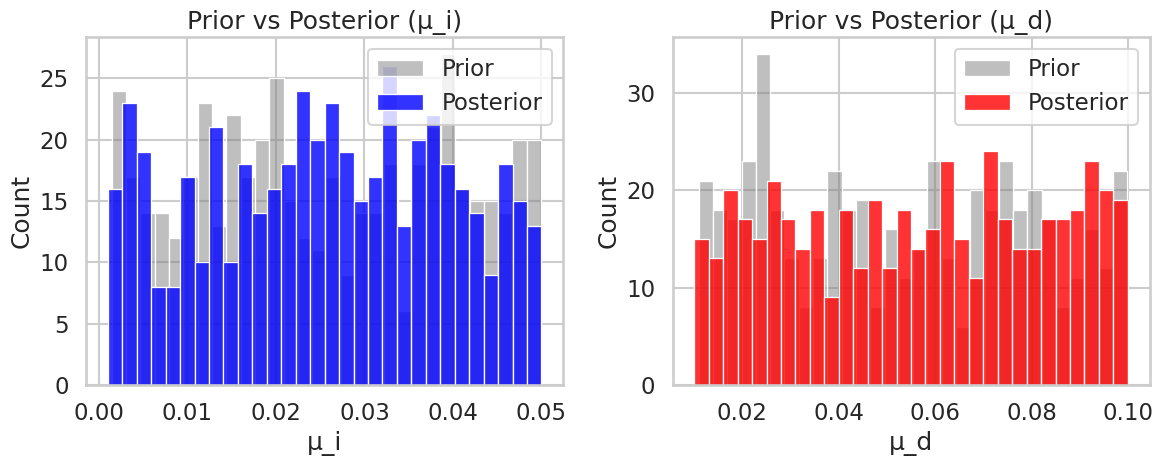

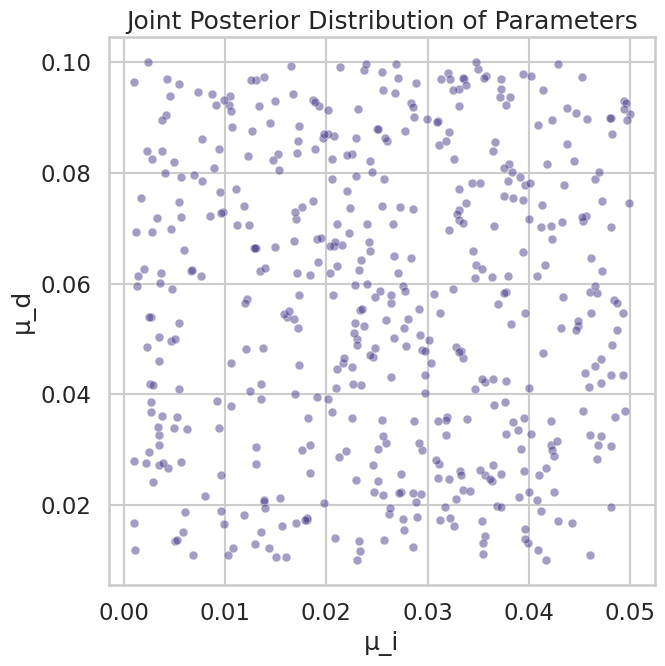

In [ ]:
import torch
import numpy as np
from torch import distributions
from tqdm import tqdm
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for publication figures
sns.set(style="whitegrid", context="talk", palette="muted")

class GPUMicrosatelliteModel:
    def __init__(self, num_loci=1000, growth_rate=0.1,
                 mu_i=0.02, mu_d=0.03, sim_time=50, device='cuda'):
        self.device = device
        self.num_loci = num_loci
        self.growth_rate = torch.tensor(growth_rate, device=device)
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.sim_time = sim_time

        self.lengths = torch.zeros(num_loci, device=device, dtype=torch.int32)
        self.counts = torch.ones(num_loci, device=device, dtype=torch.int32)

        self.delta_t = 0.1  # Ensures mu*delta_t << 1
        self.p_insert = min(self.mu_i * self.delta_t, 0.1)
        self.p_delete = min(self.mu_d * self.delta_t, 0.1)
        self.p_stay = 1 - self.p_insert - self.p_delete

        # For visualization: store historical distributions
        self.length_history = []

    def simulate(self, record_history=True):
        time = 0.0
        with torch.no_grad():
            while time < self.sim_time:
                prev_cells = torch.exp(self.growth_rate * (time - self.delta_t))
                curr_cells = torch.exp(self.growth_rate * time)
                new_cells = int((curr_cells - prev_cells).item())

                # Dynamics
                if new_cells > 0:
                    probs = self.counts.float() / self.counts.sum()
                    new_assign = torch.multinomial(probs, new_cells, replacement=True)
                    unique, counts = torch.unique(new_assign, return_counts=True)
                    self.counts[unique] += counts

                mutation_probs = torch.tensor(
                    [self.p_insert, self.p_delete, self.p_stay],
                    device=self.device
                )
                choices = torch.distributions.Categorical(mutation_probs).sample((self.num_loci,))

                self.lengths += (choices == 0).int() - (choices == 1).int()

                # Record length distribution for visualization if desired
                if record_history:
                    self.length_history.append(self.lengths.cpu().numpy().copy())

                time += self.delta_t

        return self.lengths.float().cpu().numpy()

    def plot_length_distribution(self, title="Microsatellite Lengths at Final Time"):
        final_lengths = self.lengths.cpu().numpy()
        plt.figure(figsize=(8, 5))
        sns.histplot(final_lengths, bins=30, kde=True, color='dodgerblue')
        plt.title(title)
        plt.xlabel("Length Change (bp)")
        plt.ylabel("Number of Loci")
        plt.tight_layout()
        plt.show()

    def plot_length_evolution(self):
        # Stack historic distributions
        history = np.stack(self.length_history)
        # Sample a subset if simulation is very long
        n_timesteps = min(20, len(history))
        step = len(history)//n_timesteps
        plt.figure(figsize=(10,6))
        for idx in range(0, len(history), step):
            sns.histplot(history[idx], bins=30, alpha=0.3, kde=True, label=f't={idx*self.delta_t:.1f}')
        plt.title("Evolution of Microsatellite Length Distribution")
        plt.xlabel("Length Change (bp)")
        plt.ylabel("Number of Loci")
        plt.legend(title="Simulation Time Step")
        plt.tight_layout()
        plt.show()

    def plot_length_boxplot(self):
        # Visualization of distribution shape at last simulation time
        final_lengths = self.lengths.cpu().numpy()
        plt.figure(figsize=(8,5))
        sns.boxplot(x=final_lengths, color='deepskyblue')
        plt.title("Final Microsatellite Length: Boxplot")
        plt.xlabel("Length Change (bp)")
        plt.tight_layout()
        plt.show()

class ABCInferencer:
    def __init__(self, observed_data, prior_ranges, n_particles=500):
        self.observed = observed_data
        self.priors = {
            'mu_i': distributions.Uniform(*prior_ranges['mu_i']),
            'mu_d': distributions.Uniform(*prior_ranges['mu_d'])
        }
        self.n_particles = n_particles
        self.particles = None
        self.weights = None
        # For visualizations:
        self.posterior_history = []

    def wasserstein_similarity(self, sim_data):
        return wasserstein_distance(self.observed, sim_data)

    def initialize_particles(self):
        return [{
            'mu_i': self.priors['mu_i'].sample().item(),
            'mu_d': self.priors['mu_d'].sample().item()
        } for _ in range(self.n_particles)]

    def run_smc(self, n_iter=15, eps_decay=0.9, verbose=True, vis_progress=True):
        particles = self.initialize_particles()
        eps = np.inf
        weights = np.ones(self.n_particles) / self.n_particles

        for iter in range(n_iter):
            valid = []
            distances = []

            for params in tqdm(particles):
                try:
                    model = GPUMicrosatelliteModel(**params)
                    sim_data = model.simulate(record_history=False)
                    dist = self.wasserstein_similarity(sim_data)

                    if dist < eps:
                        valid.append(params)
                        distances.append(dist)
                except:
                    continue

            if len(valid) < 10:
                eps *= 1.2
                particles = self.initialize_particles()
                if verbose: print(f"Reset particles at iteration {iter+1}")
                continue

            eps = np.percentile(distances, 50) * eps_decay
            weights = np.exp(-np.array(distances)/eps)
            weights /= weights.sum()

            resample_idx = np.random.choice(range(len(valid)), size=self.n_particles, p=weights)
            new_particles = [valid[i] for i in resample_idx]

            particles = [{
                'mu_i': max(0.001, p['mu_i'] + np.random.normal(0, 0.005)),
                'mu_d': max(0.001, p['mu_d'] + np.random.normal(0, 0.005))
            } for p in new_particles]

            # Store for plotting
            self.posterior_history.append(particles.copy())

            if verbose:
                print(f"Iter {iter+1}: ε={eps:.4f}, Survived {len(valid)}")
                print(f"μ_i: {np.mean([p['mu_i'] for p in particles]):.5f} ± {np.std([p['mu_i'] for p in particles]):.5f}")
                print(f"μ_d: {np.mean([p['mu_d'] for p in particles]):.5f} ± {np.std([p['mu_d'] for p in particles]):.5f}\n")

            # Progress visualizations of parameter particles
            if vis_progress:
                self.plot_posterior_density(iter)

        self.particles = particles
        return particles

    def plot_posterior_density(self, iteration):
        # Collect all posterior particles for current iteration
        particles = self.posterior_history[iteration]
        mu_is = [p['mu_i'] for p in particles]
        mu_ds = [p['mu_d'] for p in particles]

        plt.figure(figsize=(11,5))
        plt.subplot(121)
        sns.histplot(mu_is, bins=30, kde=True, color='purple')
        plt.title(f"μ_i Posterior Density (Iter {iteration+1})")
        plt.xlabel("μ_i")
        plt.ylabel("Posterior Particle Count")

        plt.subplot(122)
        sns.histplot(mu_ds, bins=30, kde=True, color='orange')
        plt.title(f"μ_d Posterior Density (Iter {iteration+1})")
        plt.xlabel("μ_d")
        plt.ylabel("Posterior Particle Count")
        plt.tight_layout()
        plt.show()

    def plot_prior_posterior(self):
        # Show prior vs final posterior for both parameters
        pri_mu_i = self.priors['mu_i'].sample((self.n_particles,)).cpu().numpy()
        pri_mu_d = self.priors['mu_d'].sample((self.n_particles,)).cpu().numpy()
        post_mu_i = [p['mu_i'] for p in self.particles]
        post_mu_d = [p['mu_d'] for p in self.particles]

        plt.figure(figsize=(12,5))
        plt.subplot(121)
        sns.histplot(pri_mu_i, bins=30, color='gray', label='Prior', alpha=0.5)
        sns.histplot(post_mu_i, bins=30, color='blue', label='Posterior', alpha=0.8)
        plt.title("Prior vs Posterior (μ_i)")
        plt.xlabel("μ_i")
        plt.legend()

        plt.subplot(122)
        sns.histplot(pri_mu_d, bins=30, color='gray', label='Prior', alpha=0.5)
        sns.histplot(post_mu_d, bins=30, color='red', label='Posterior', alpha=0.8)
        plt.title("Prior vs Posterior (μ_d)")
        plt.xlabel("μ_d")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_parameter_joint(self):
        # Scatter plot of joint parameter posterior
        mu_is = [p['mu_i'] for p in self.particles]
        mu_ds = [p['mu_d'] for p in self.particles]
        plt.figure(figsize=(7,7))
        sns.scatterplot(x=mu_is, y=mu_ds, color='darkslateblue', s=40, alpha=0.5)
        plt.xlabel("μ_i")
        plt.ylabel("μ_d")
        plt.title("Joint Posterior Distribution of Parameters")
        plt.tight_layout()
        plt.show()


# Validation Example
if __name__ == "__main__":
    # Generate validation data
    true_params = {'mu_i': 0.015, 'mu_d': 0.085, 'growth_rate': 0.244, 'sim_time': 35}
    model = GPUMicrosatelliteModel(**true_params)
    observed_data = model.simulate()

    # Publication-quality figure: Length distribution
    model.plot_length_distribution(title="Observed Final Microsatellite Lengths (True Params)")
    model.plot_length_boxplot()
    model.plot_length_evolution()

    prior_ranges = {
      'mu_i': (0.001, 0.05),
      'mu_d': (0.01, 0.1)
    }

    inferencer = ABCInferencer(observed_data, prior_ranges, n_particles=500)
    results = inferencer.run_smc(n_iter=10)

    # Analyze results and plot
    mu_i_est = np.mean([p['mu_i'] for p in results])
    mu_d_est = np.mean([p['mu_d'] for p in results])
    print(f"\nTrue parameters: mu_i={true_params['mu_i']}, mu_d={true_params['mu_d']}")
    print(f"Estimated parameters: mu_i={mu_i_est:.5f}, mu_d={mu_d_est:.5f}")

    # Publication-quality posterior visualizations
    inferencer.plot_prior_posterior()
    inferencer.plot_parameter_joint()


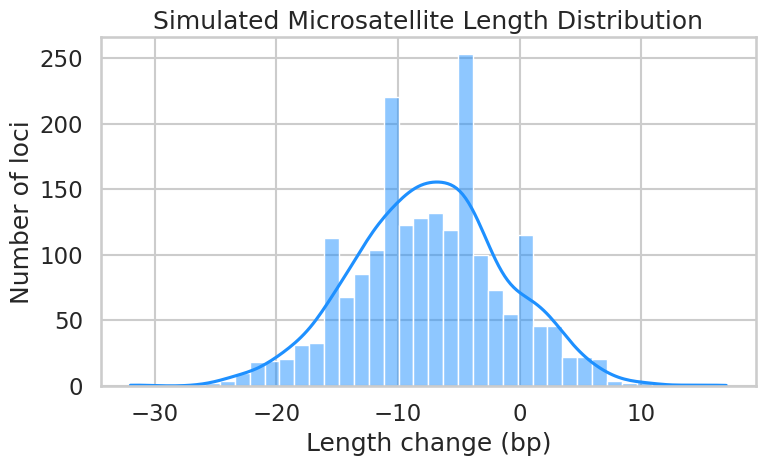

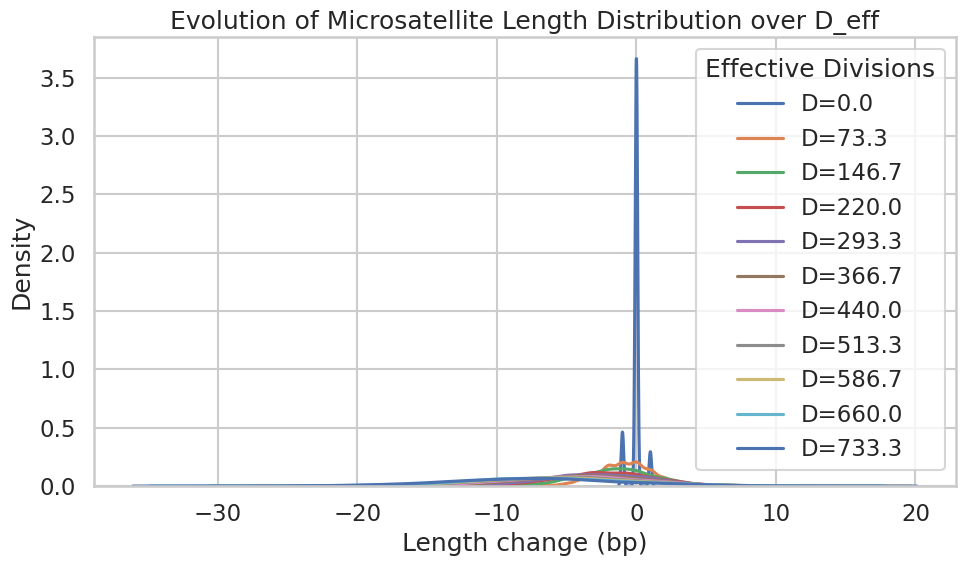

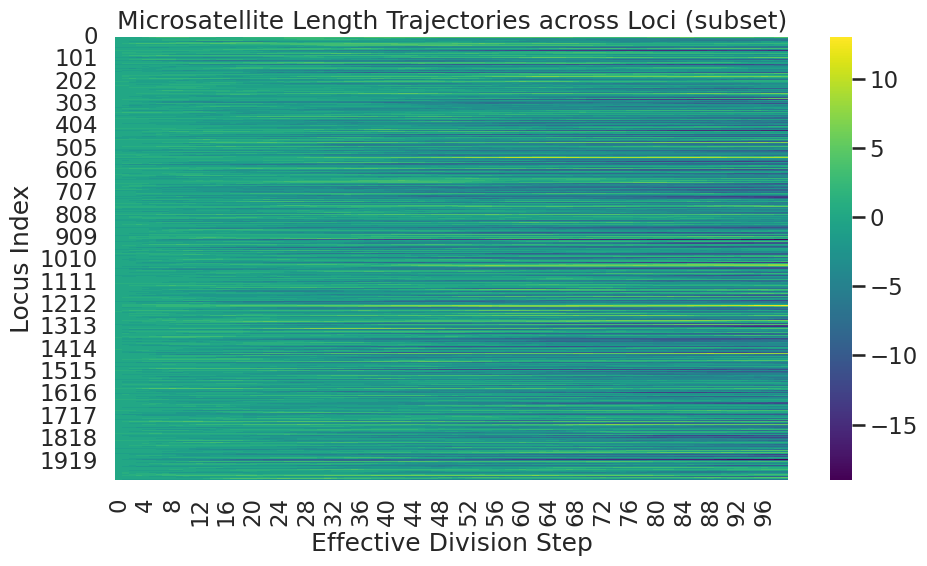

Gen 1: 100%|██████████| 500/500 [00:38<00:00, 13.10it/s]


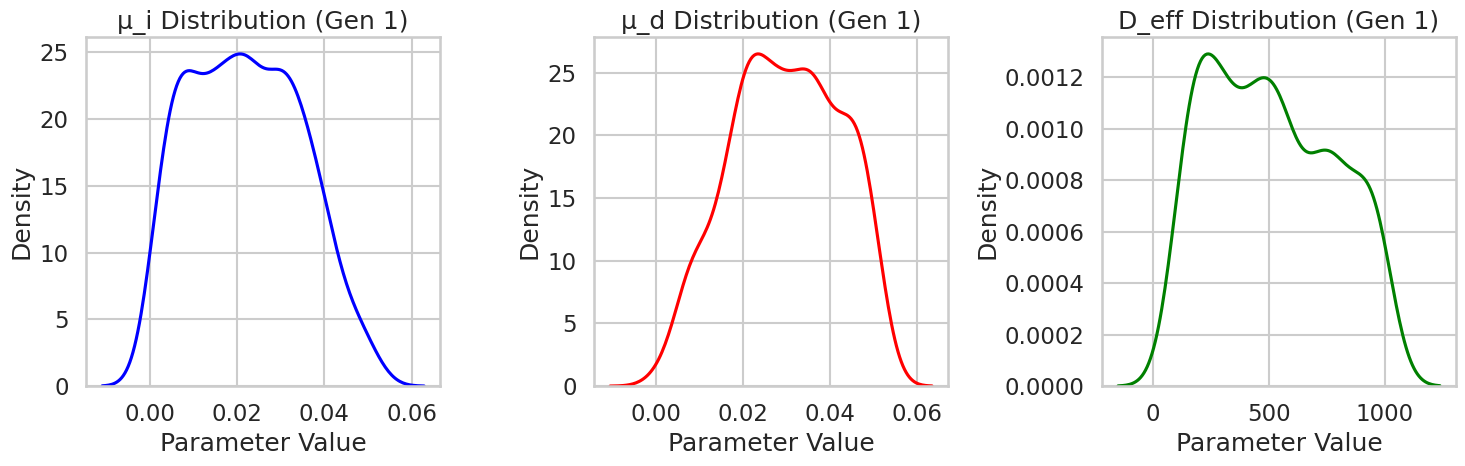

Gen 2: 100%|██████████| 500/500 [00:31<00:00, 15.90it/s]


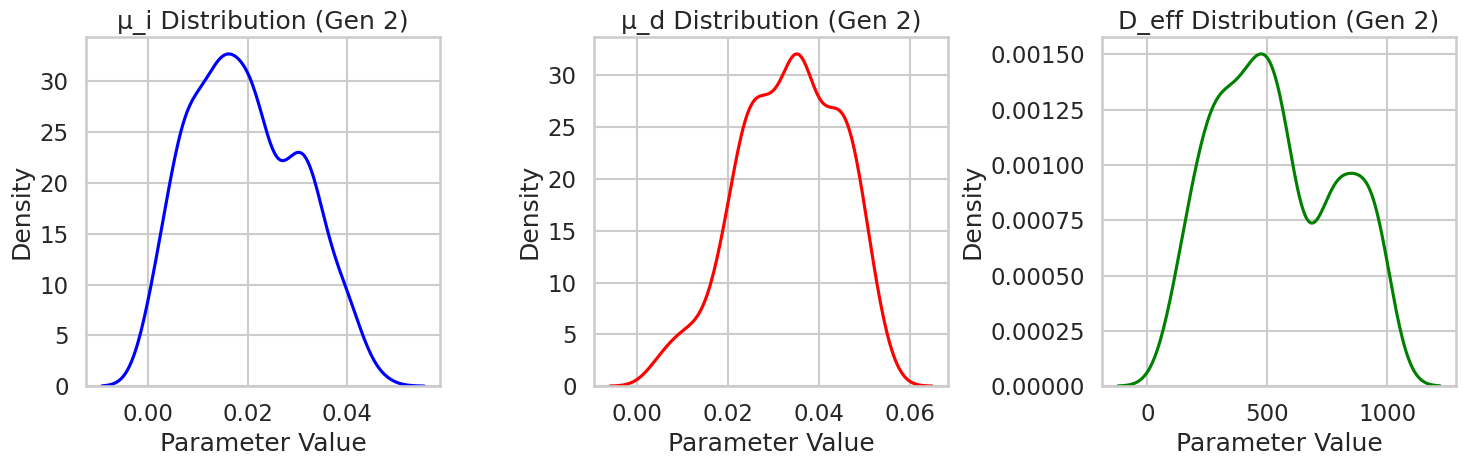

Gen 3: 100%|██████████| 500/500 [00:41<00:00, 12.07it/s]


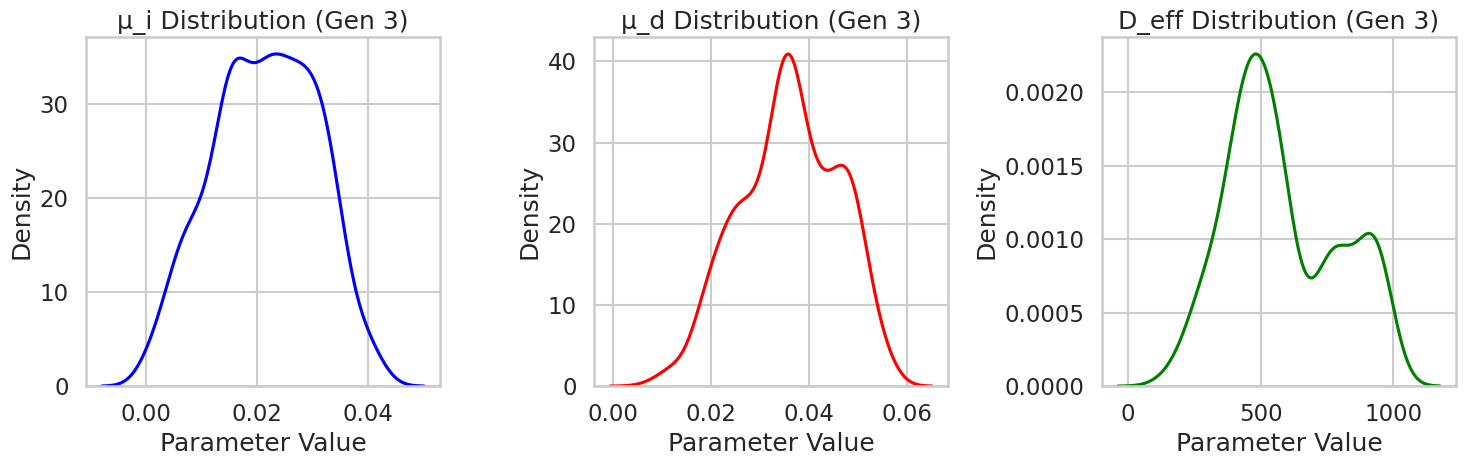

Gen 4: 100%|██████████| 500/500 [00:39<00:00, 12.57it/s]


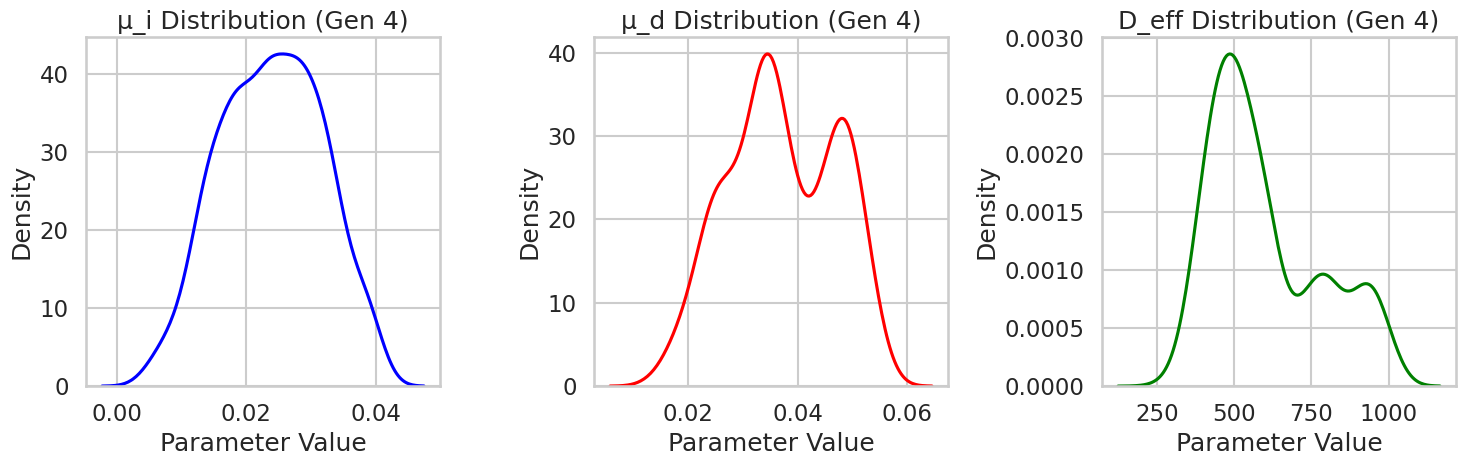

Gen 5: 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


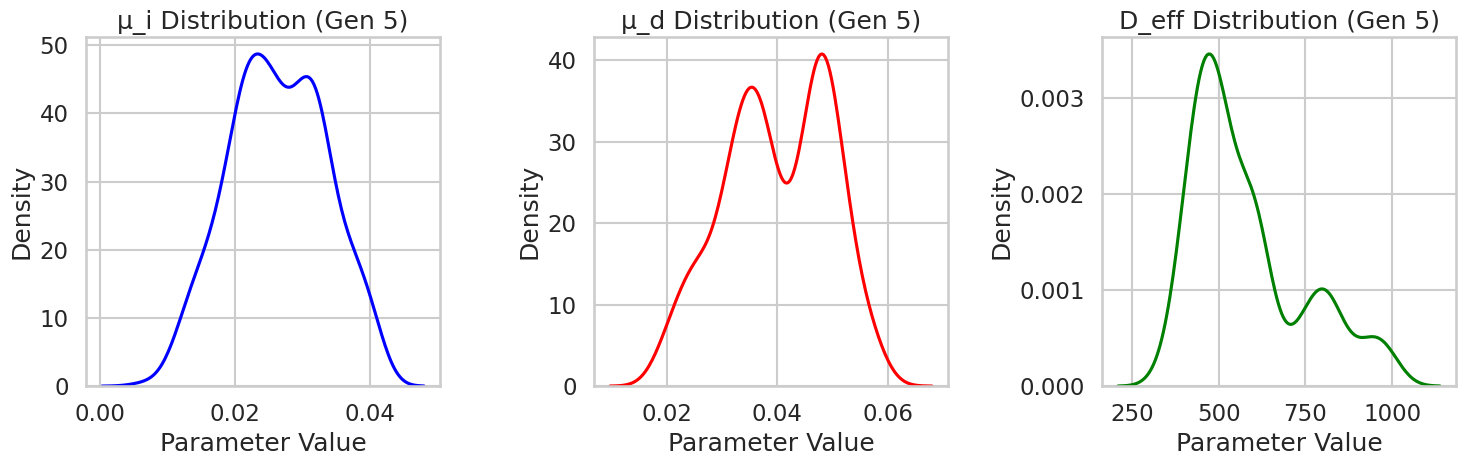

Gen 6: 100%|██████████| 500/500 [00:43<00:00, 11.57it/s]


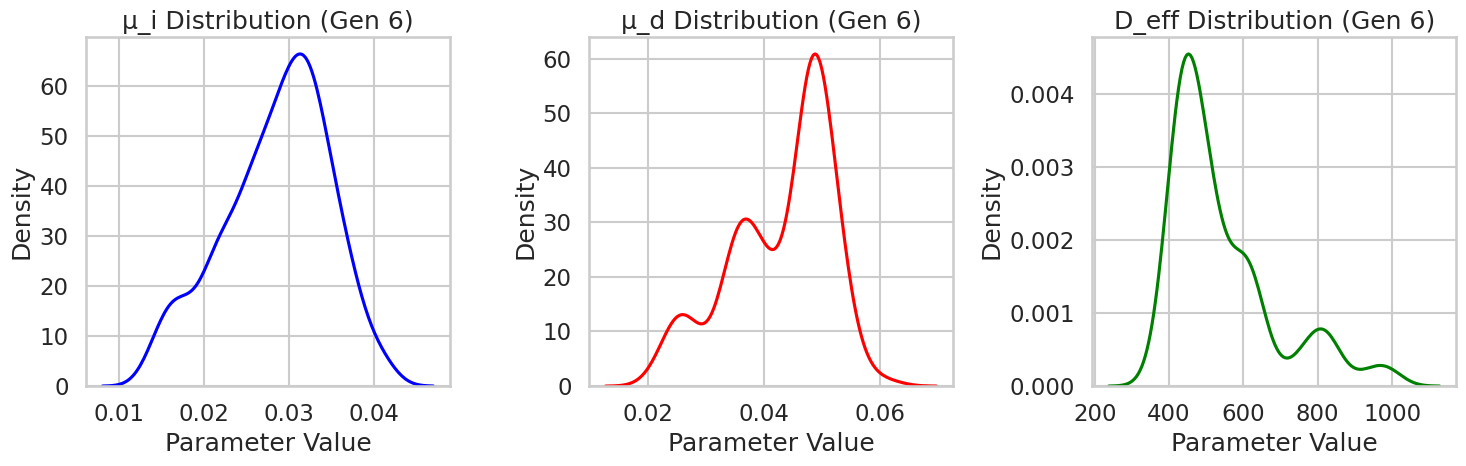

Gen 7: 100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


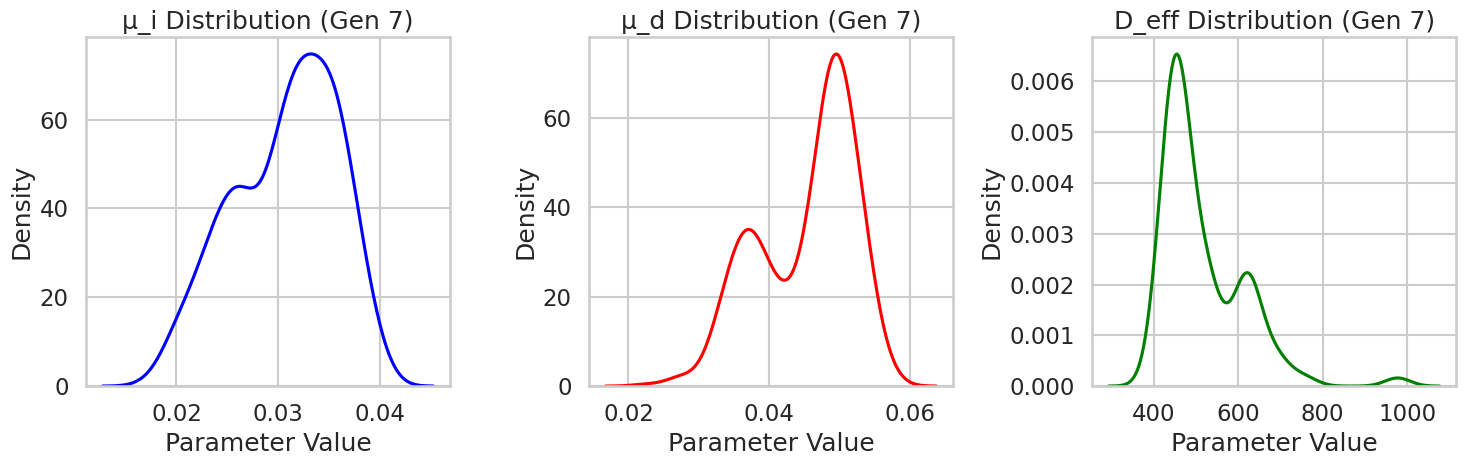

Gen 8: 100%|██████████| 500/500 [00:45<00:00, 10.96it/s]


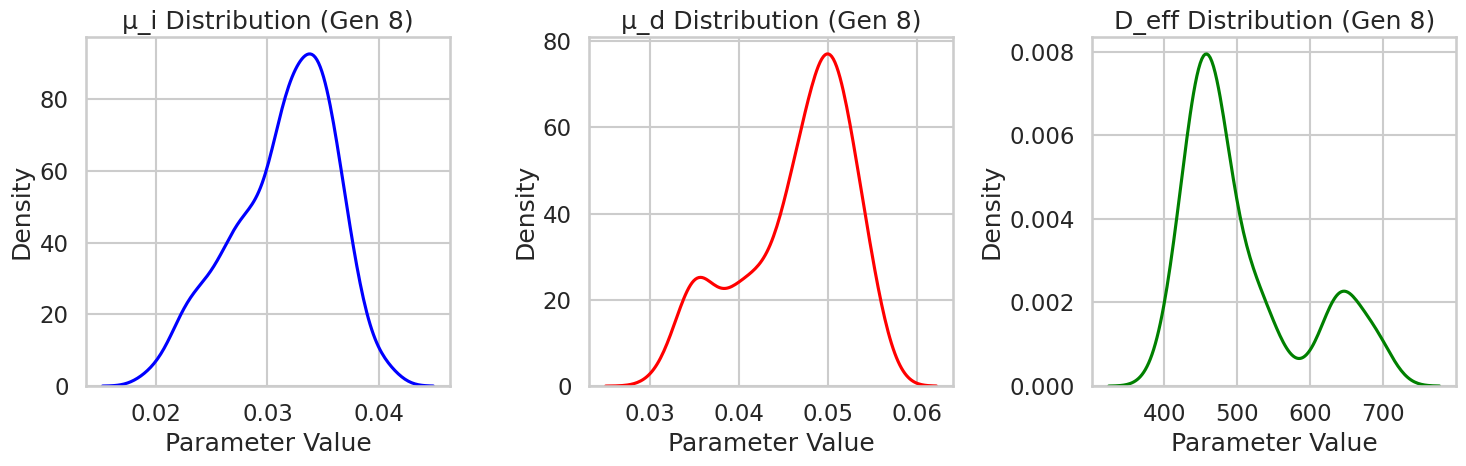

Gen 9: 100%|██████████| 500/500 [00:46<00:00, 10.81it/s]


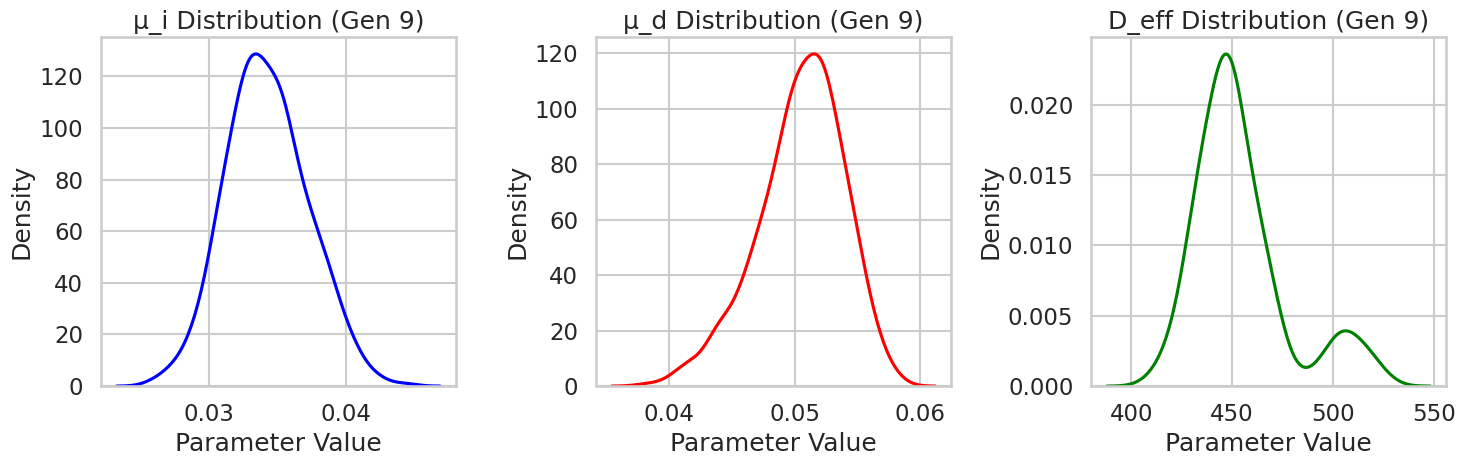

Gen 11: 100%|██████████| 500/500 [00:45<00:00, 10.91it/s]


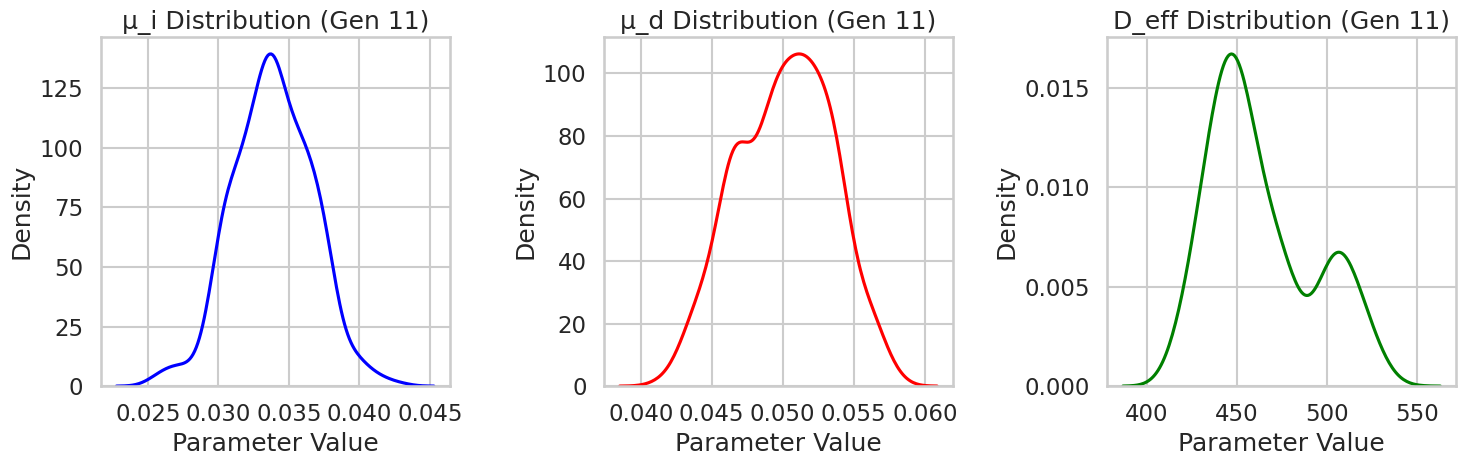

Gen 12: 100%|██████████| 500/500 [00:46<00:00, 10.69it/s]


True: μ_i=0.02, μ_d=0.03, D_eff=750
Estimated: μ_i=0.0339, μ_d=0.0501, D_eff=463.23


In [ ]:
import torch
import numpy as np
from torch.distributions import Categorical, Uniform
from tqdm import tqdm
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

class MicrosatelliteEvoModel:
    """
    GPU-based stochastic Markov model of microsatellite evolution
    Inspired by EVOFLUX: evolving through indel transitions with effective divisions D_eff.
    """
    def __init__(self, num_loci=2000, mu_i=0.02, mu_d=0.03, D_eff=1000, device='cuda'):
        self.device = device
        self.num_loci = num_loci
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.D_eff = D_eff   # Effective total divisions (replaces r*T)

        # Initialize loci
        self.lengths = torch.zeros(num_loci, dtype=torch.int32, device=device)
        self.delta_div = 0.1 / max(mu_i, mu_d, 1e-6)
        self.p_insert = mu_i * self.delta_div
        self.p_delete = mu_d * self.delta_div
        self.p_stay = 1 - self.p_insert - self.p_delete

        # History for visualization
        self.history = []

    def stochastic_step(self):
        """Single Markov jump update for all loci."""
        probs = torch.tensor(
            [self.p_insert, self.p_delete, self.p_stay], device=self.device
        )
        transitions = Categorical(probs).sample((self.num_loci,))
        self.lengths += (transitions == 0).int() - (transitions == 1).int()

    def simulate(self, record_history=True):
        """Simulate stochastic microsatellite evolution up to D_eff divisions."""
        n_steps = int(self.D_eff / self.delta_div)
        for _ in range(n_steps):
            self.stochastic_step()
            if record_history:
                self.history.append(self.lengths.cpu().numpy().copy())
        return self.lengths.cpu().numpy()

    # === Visualization functions ===
    def plot_final_distribution(self, title="Final Microsatellite Length Distribution"):
        plt.figure(figsize=(8,5))
        sns.histplot(self.lengths.cpu().numpy(), bins=40, kde=True, color='dodgerblue')
        plt.title(title)
        plt.xlabel("Length change (bp)")
        plt.ylabel("Number of loci")
        plt.tight_layout()
        plt.show()

    def plot_evolution_heatmap(self):
        """Show evolution of distribution over effective divisions."""
        mat = np.stack(self.history)
        plt.figure(figsize=(10,6))
        sns.heatmap(mat[:100].T, cmap="viridis", cbar=True)
        plt.title("Microsatellite Length Trajectories across Loci (subset)")
        plt.xlabel("Effective Division Step")
        plt.ylabel("Locus Index")
        plt.tight_layout()
        plt.show()

    def plot_length_distribution_over_time(self):
        """Overlay histogram snapshots of evolving distribution."""
        n_frames = min(10, len(self.history))
        step = len(self.history)//n_frames
        plt.figure(figsize=(10,6))
        for i in range(0, len(self.history), step):
            sns.kdeplot(self.history[i], label=f"D={i*self.delta_div:.1f}")
        plt.title("Evolution of Microsatellite Length Distribution over D_eff")
        plt.xlabel("Length change (bp)")
        plt.ylabel("Density")
        plt.legend(title="Effective Divisions")
        plt.tight_layout()
        plt.show()

class ABCDeffInferencer:
    """
    Approximate Bayesian Computation - Sequential Monte Carlo inference
    Extended to infer D_eff together with μ_i, μ_d.
    """
    def __init__(self, observed, prior_ranges, n_particles=500):
        self.observed = observed
        self.priors = {
            'mu_i': Uniform(*prior_ranges['mu_i']),
            'mu_d': Uniform(*prior_ranges['mu_d']),
            'D_eff': Uniform(*prior_ranges['D_eff'])
        }
        self.n_particles = n_particles
        self.posterior = []

    def wasserstein(self, sim):
        return wasserstein_distance(self.observed, sim)

    def initialize_particles(self):
        return [{
            'mu_i': self.priors['mu_i'].sample().item(),
            'mu_d': self.priors['mu_d'].sample().item(),
            'D_eff': self.priors['D_eff'].sample().item()
        } for _ in range(self.n_particles)]

    def run(self, n_iter=10, eps_decay=0.9):
        particles = self.initialize_particles()
        eps = np.inf

        for gen in range(n_iter):
            valid, distances = [], []
            for p in tqdm(particles, desc=f"Gen {gen+1}"):
                try:
                    model = MicrosatelliteEvoModel(num_loci=1000,
                        mu_i=p['mu_i'], mu_d=p['mu_d'], D_eff=p['D_eff'])
                    sim = model.simulate(record_history=False)
                    d = self.wasserstein(sim)
                    if d < eps:
                        valid.append(p)
                        distances.append(d)
                except:
                    continue

            if len(valid) < 10:
                eps *= 1.2
                continue

            eps = np.percentile(distances, 50) * eps_decay
            weights = np.exp(-np.array(distances) / eps)
            weights /= weights.sum()

            idx = np.random.choice(range(len(valid)), self.n_particles, p=weights)
            new_particles = [valid[i].copy() for i in idx]

            # Gaussian jitter
            for p in new_particles:
                p['mu_i'] = max(1e-4, p['mu_i'] + np.random.normal(0, 0.002))
                p['mu_d'] = max(1e-4, p['mu_d'] + np.random.normal(0, 0.002))
                p['D_eff'] = max(50, p['D_eff'] + np.random.normal(0, 10))

            particles = new_particles
            self.posterior = particles.copy()
            self.plot_posterior(gen)

        return particles

    def plot_posterior(self, generation):
        mu_i_vals = [p['mu_i'] for p in self.posterior]
        mu_d_vals = [p['mu_d'] for p in self.posterior]
        D_vals = [p['D_eff'] for p in self.posterior]

        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        sns.kdeplot(mu_i_vals, ax=axes[0], color='blue')
        axes[0].set_title(f"μ_i Distribution (Gen {generation+1})")

        sns.kdeplot(mu_d_vals, ax=axes[1], color='red')
        axes[1].set_title(f"μ_d Distribution (Gen {generation+1})")

        sns.kdeplot(D_vals, ax=axes[2], color='green')
        axes[2].set_title(f"D_eff Distribution (Gen {generation+1})")

        for a in axes:
            a.set_xlabel("Parameter Value")
            a.set_ylabel("Density")
        plt.tight_layout()
        plt.show()

# ===== Example usage =====
if __name__ == "__main__":
    # Simulate synthetic data with known parameters
    true_params = {'mu_i': 0.02, 'mu_d': 0.03, 'D_eff': 750}
    model = MicrosatelliteEvoModel(**true_params)
    observed_data = model.simulate(record_history=True)

    # Visualizations for demonstration
    model.plot_final_distribution("Simulated Microsatellite Length Distribution")
    model.plot_length_distribution_over_time()
    model.plot_evolution_heatmap()

    # Set priors
    priors = {
        'mu_i': (0.001, 0.05),
        'mu_d': (0.001, 0.05),
        'D_eff': (100, 1000)
    }

    infer = ABCDeffInferencer(observed_data, priors, n_particles=500)
    results = infer.run(n_iter=12)

    # Final posterior summary
    mu_i_est = np.mean([p['mu_i'] for p in results])
    mu_d_est = np.mean([p['mu_d'] for p in results])
    Deff_est = np.mean([p['D_eff'] for p in results])
    print(f"\nTrue: μ_i={true_params['mu_i']}, μ_d={true_params['mu_d']}, D_eff={true_params['D_eff']}")
    print(f"Estimated: μ_i={mu_i_est:.4f}, μ_d={mu_d_est:.4f}, D_eff={Deff_est:.2f}")


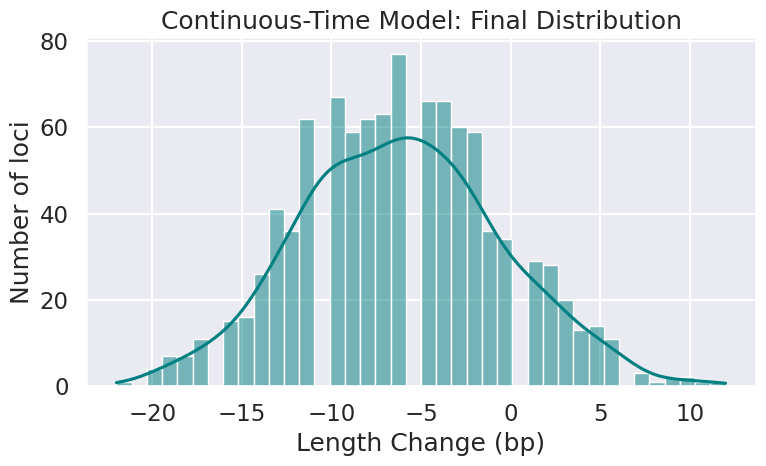

/tmp/ipython-input-3653104304.py:59: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(histories[i], label=f"t={i}")


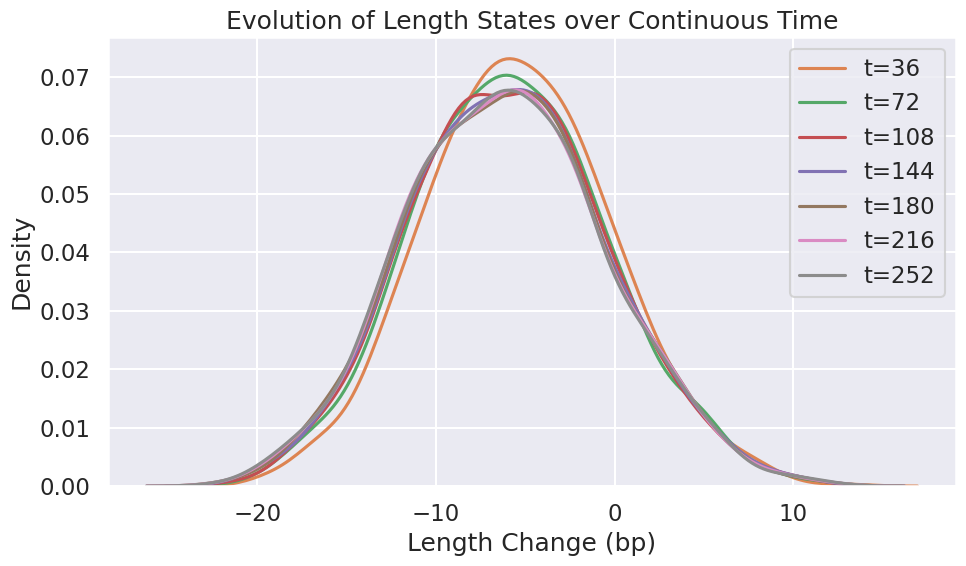

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk")

class MicrosatelliteCTMCModel:
    """
    Continuous-time Markov chain model for microsatellite evolution, with Gillespie simulation.
    """
    def __init__(self, num_loci=1000, mu_i=0.02, mu_d=0.03, total_time=500):
        self.num_loci = num_loci
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.total_time = total_time

    def simulate(self, record_history=False):
        # Each locus starts at zero length
        lengths = np.zeros(self.num_loci, dtype=int)
        times = np.zeros(self.num_loci)
        # For optional visualization
        histories = [lengths.copy()] if record_history else None

        # For each locus, list of event times
        while np.any(times < self.total_time):
            # Which loci will have next event soonest?
            rate_sum = self.mu_i + self.mu_d
            wait_times = np.where(times < self.total_time, np.random.exponential(1/rate_sum, self.num_loci), np.inf)
            indices = np.where((times + wait_times) < self.total_time)[0]
            if len(indices) == 0:
                break
            for idx in indices:
                times[idx] += wait_times[idx]
                # Determine insertion or deletion
                if np.random.rand() < (self.mu_i / rate_sum):
                    lengths[idx] += 1
                else:
                    lengths[idx] -= 1
            if record_history:
                histories.append(lengths.copy())
        if record_history:
            return lengths, histories
        else:
            return lengths

    # Visualization
    def plot_final_distribution(self, lengths, title="Final Length Distribution"):
        plt.figure(figsize=(8,5))
        sns.histplot(lengths, bins=40, kde=True, color='teal')
        plt.title(title)
        plt.xlabel("Length Change (bp)")
        plt.ylabel("Number of loci")
        plt.tight_layout()
        plt.show()

    def plot_evolution(self, histories, n_frames=8):
        step = max(1, len(histories)//n_frames)
        plt.figure(figsize=(10,6))
        for i in range(0, len(histories), step):
            sns.kdeplot(histories[i], label=f"t={i}")
        plt.xlabel("Length Change (bp)")
        plt.ylabel("Density")
        plt.title("Evolution of Length States over Continuous Time")
        plt.legend()
        plt.tight_layout()
        plt.show()

# ==== Example Usage ====
if __name__ == "__main__":
    # Setup model
    model = MicrosatelliteCTMCModel(num_loci=1000, mu_i=0.02, mu_d=0.03, total_time=500)
    lengths, histories = model.simulate(record_history=True)
    # Plots
    model.plot_final_distribution(lengths, "Continuous-Time Model: Final Distribution")
    model.plot_evolution(histories)


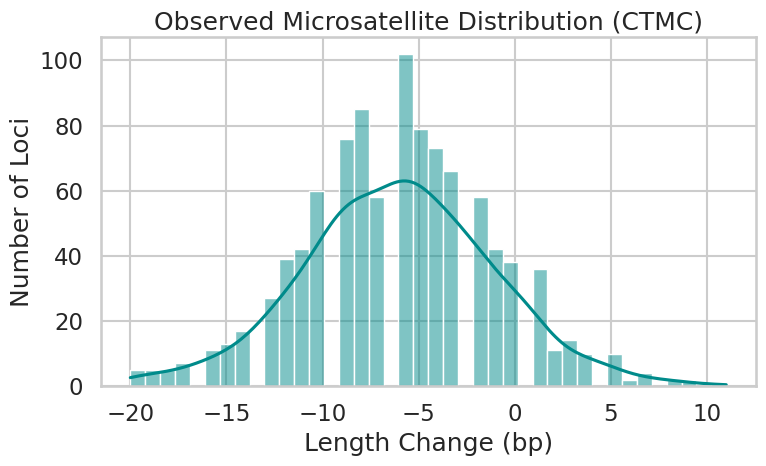

/tmp/ipython-input-408605788.py:91: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(history[i], label=f"t={i*self.record_interval}")


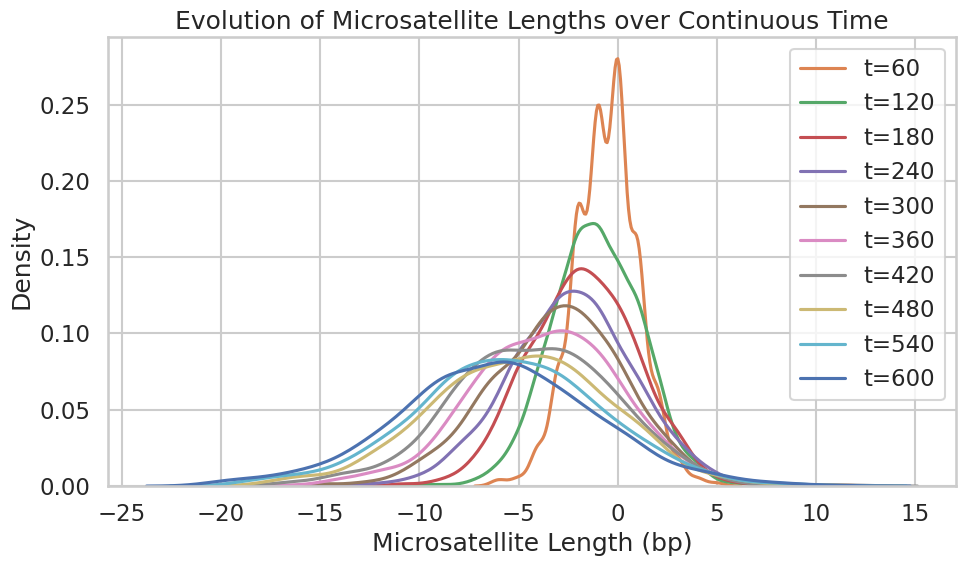

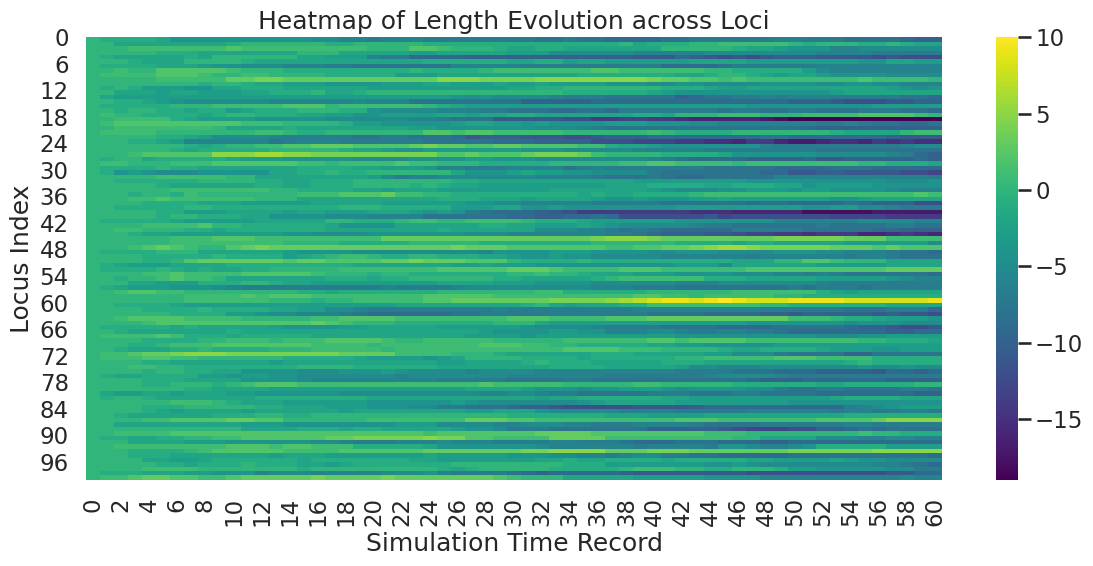

Generation 1: 100%|██████████| 400/400 [00:27<00:00, 14.46it/s]


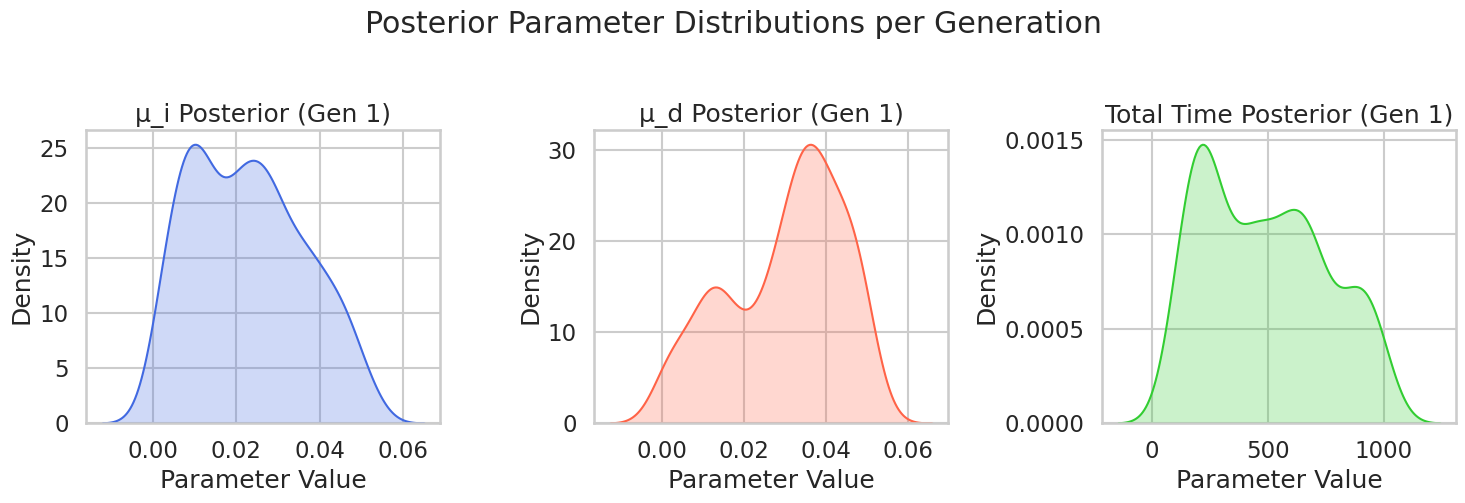

Generation 2: 100%|██████████| 400/400 [00:24<00:00, 16.43it/s]


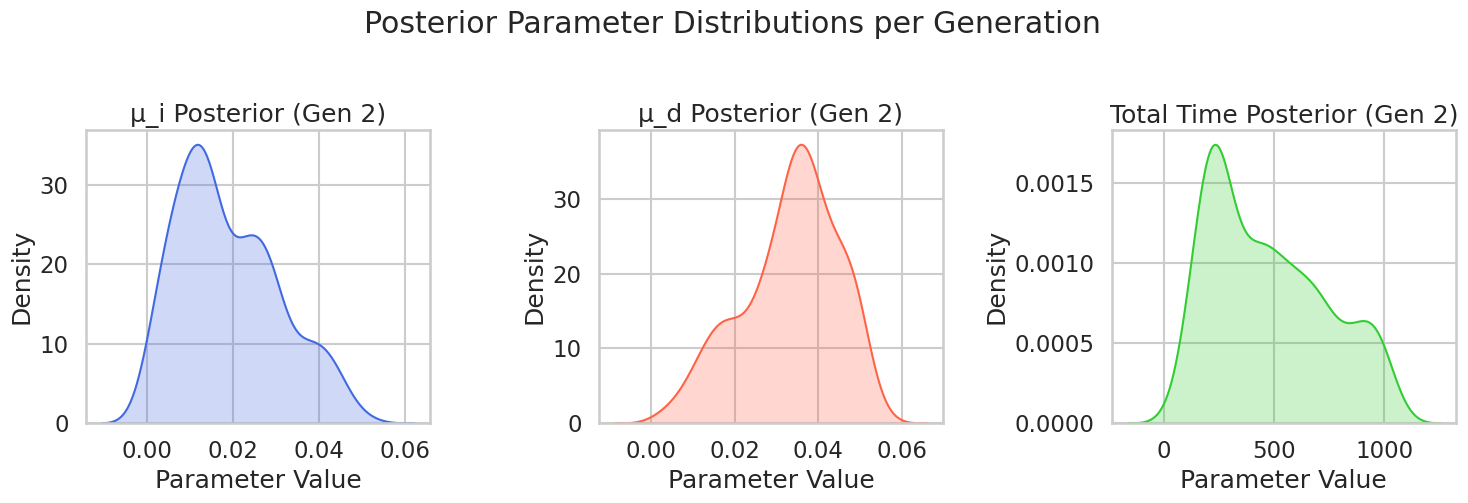

Generation 3: 100%|██████████| 400/400 [00:23<00:00, 17.37it/s]


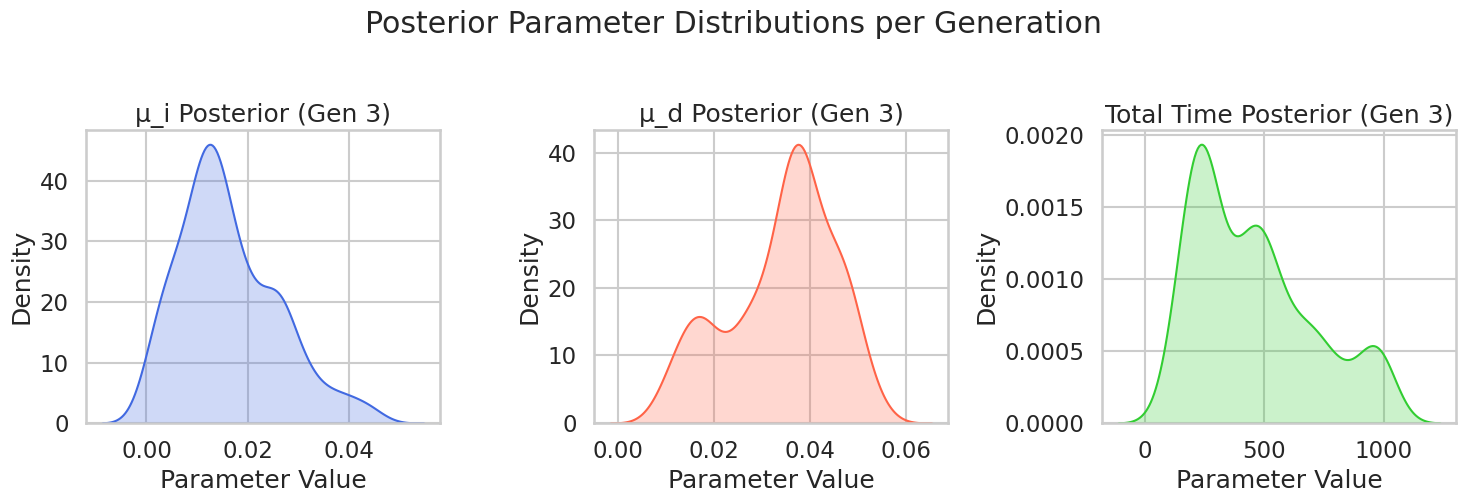

Generation 4: 100%|██████████| 400/400 [00:20<00:00, 19.18it/s]


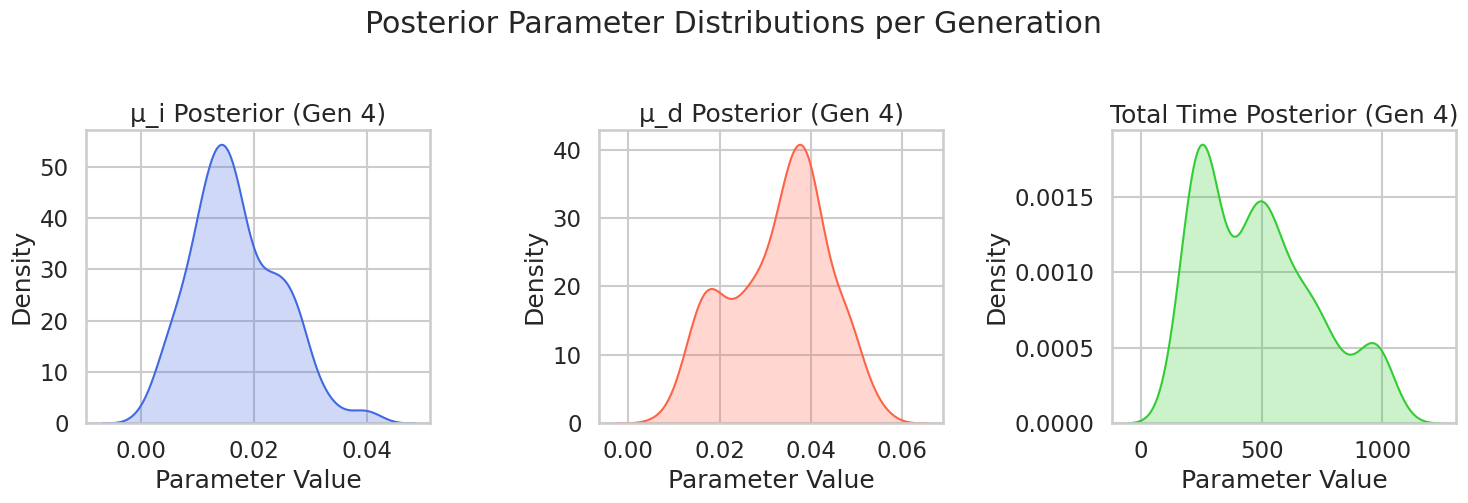

Generation 5: 100%|██████████| 400/400 [00:21<00:00, 18.53it/s]


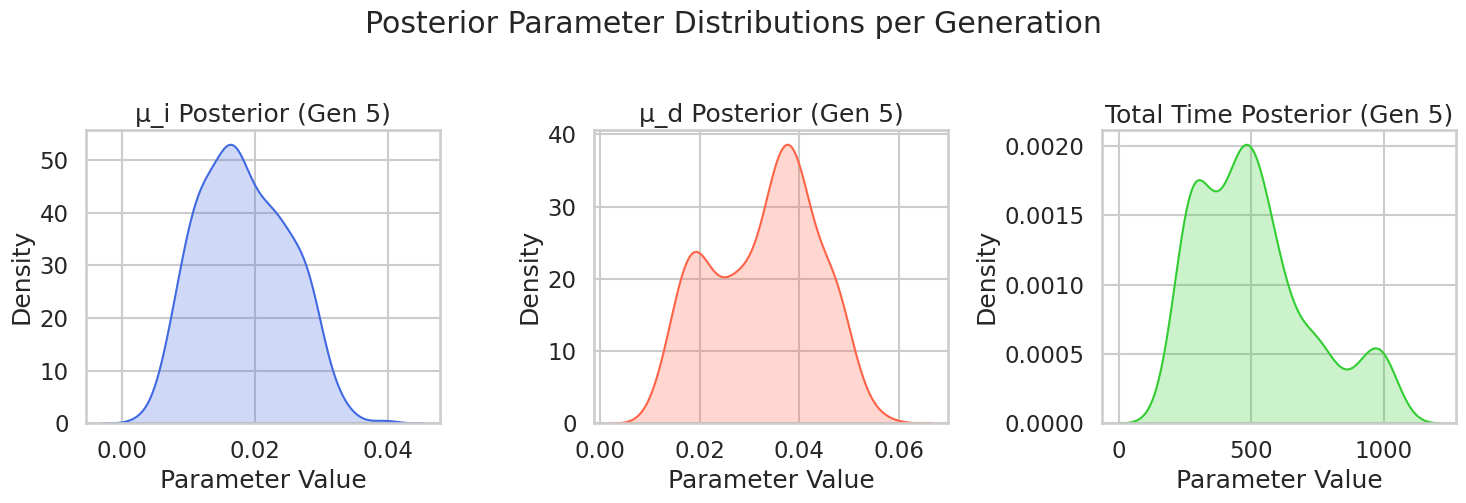

Generation 6: 100%|██████████| 400/400 [00:23<00:00, 17.38it/s]


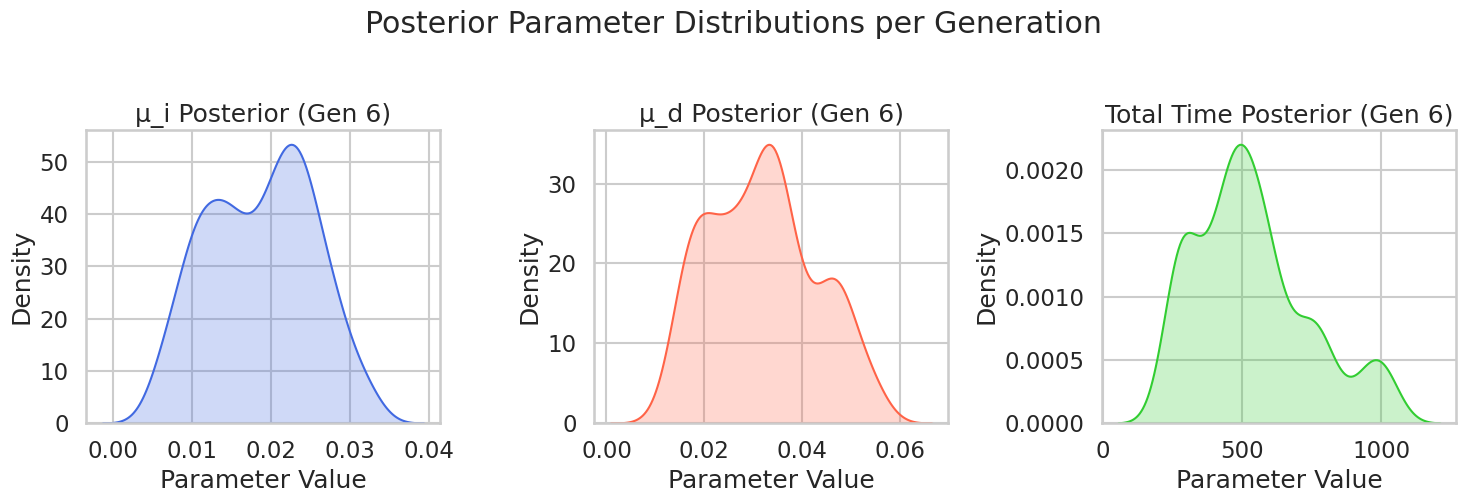


Parameter Estimates:
True values: μ_i = 0.015, μ_d = 0.025, Total time = 600
Estimated:  μ_i = 0.0186, μ_d = 0.0318, Total time = 533.45


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from tqdm import tqdm

sns.set(style="whitegrid", context="talk", palette="deep")

# ===========================================================
# CONTINUOUS-TIME MARKOV CHAIN MODEL FOR MICROSATELLITE EVOLUTION
# ===========================================================

class MicrosatelliteCTMCModel:
    """
    Continuous-Time Markov Chain (CTMC) model for microsatellite evolution.
    Uses the Gillespie algorithm to simulate stochastic insertions and deletions.

    Biological mapping:
      - Each locus = independent integer state L(t)
      - Transitions:
            L -> L+1 at rate μ_i
            L -> L-1 at rate μ_d
      - Time proceeds continuously with exponentially distributed waiting times
    """
    def __init__(self, num_loci=1000, mu_i=0.02, mu_d=0.03, total_time=1000, record_interval=10):
        self.num_loci = num_loci
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.total_time = total_time
        self.record_interval = record_interval

    def simulate(self, record_history=True):
        """
        Simulate the CTMC using the Gillespie algorithm.
        Returns:
            final_lengths (np.ndarray): array of final loci lengths at time = total_time
            history (list[np.ndarray]): time series of lengths (optional)
        """
        lengths = np.zeros(self.num_loci, dtype=int)
        t = 0.0

        if record_history:
            history = [lengths.copy()]
            next_record = self.record_interval
        else:
            history = None

        rng = np.random.default_rng()

        while t < self.total_time:
            # Each locus has total rate equal to (μ_i + μ_d)
            total_rate = self.num_loci * (self.mu_i + self.mu_d)
            if total_rate == 0:
                break

            # Draw next event time
            tau = rng.exponential(1 / total_rate)
            t += tau

            # Choose random locus and type of event
            locus = rng.integers(0, self.num_loci)
            if rng.random() < self.mu_i / (self.mu_i + self.mu_d):
                lengths[locus] += 1
            else:
                lengths[locus] -= 1

            if record_history and t >= next_record:
                history.append(lengths.copy())
                next_record += self.record_interval

        return lengths, history

    # ===========================================================
    # VISUALIZATION FUNCTIONS
    # ===========================================================

    def plot_final_distribution(self, lengths, title="Final Microsatellite Length Distribution"):
        plt.figure(figsize=(8,5))
        sns.histplot(lengths, bins=40, kde=True, color='darkcyan', edgecolor=None)
        plt.title(title)
        plt.xlabel("Length Change (bp)")
        plt.ylabel("Number of Loci")
        plt.tight_layout()
        plt.show()

    def plot_evolution(self, history):
        n_frames = min(10, len(history))
        step = max(1, len(history)//n_frames)
        plt.figure(figsize=(10,6))
        for i in range(0, len(history), step):
            sns.kdeplot(history[i], label=f"t={i*self.record_interval}")
        plt.xlabel("Microsatellite Length (bp)")
        plt.ylabel("Density")
        plt.title("Evolution of Microsatellite Lengths over Continuous Time")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_heatmap(self, history):
        mat = np.stack(history)
        plt.figure(figsize=(12,6))
        sns.heatmap(mat.T[:100, :], cmap="viridis", cbar=True)
        plt.title("Heatmap of Length Evolution across Loci")
        plt.xlabel("Simulation Time Record")
        plt.ylabel("Locus Index")
        plt.tight_layout()
        plt.show()

# ===========================================================
# ABC-SMC PARAMETER INFERENCE FOR CTMC MODEL
# ===========================================================

class ABCCTMCInferencer:
    """
    ABC-SMC inference applied to CTMC microsatellite model.
    Infers μ_i, μ_d, and effective total time (or divisions).
    """
    def __init__(self, observed_data, prior_ranges, n_particles=500):
        self.observed = observed_data
        self.priors = prior_ranges
        self.n_particles = n_particles
        self.posterior_history = []

    def wasserstein_dist(self, sim):
        return wasserstein_distance(self.observed, sim)

    def sample_priors(self, rng):
        return {
            'mu_i': rng.uniform(*self.priors['mu_i']),
            'mu_d': rng.uniform(*self.priors['mu_d']),
            'total_time': rng.uniform(*self.priors['total_time'])
        }

    def run(self, n_iter=8, eps_decay=0.9):
        rng = np.random.default_rng()
        particles = [self.sample_priors(rng) for _ in range(self.n_particles)]
        eps = np.inf

        for gen in range(n_iter):
            valid = []
            distances = []
            for p in tqdm(particles, desc=f"Generation {gen+1}"):
                model = MicrosatelliteCTMCModel(num_loci=500, mu_i=p['mu_i'], mu_d=p['mu_d'], total_time=p['total_time'])
                lengths, _ = model.simulate(record_history=False)
                d = self.wasserstein_dist(lengths)
                if d < eps:
                    valid.append(p)
                    distances.append(d)

            # Adaptive epsilon
            if len(valid) < 10:
                eps *= 1.2
                continue

            eps = np.percentile(distances, 50) * eps_decay
            weights = np.exp(-np.array(distances)/eps)
            weights /= weights.sum()

            idx = np.random.choice(len(valid), self.n_particles, p=weights)
            new_particles = [valid[i].copy() for i in idx]

            # Gaussian jitter
            for p in new_particles:
                p['mu_i'] = max(1e-4, p['mu_i'] + rng.normal(0, 0.002))
                p['mu_d'] = max(1e-4, p['mu_d'] + rng.normal(0, 0.002))
                p['total_time'] = max(10, p['total_time'] + rng.normal(0, 10))

            particles = new_particles
            self.posterior_history.append(particles.copy())
            self.plot_posterior_distribution(particles, gen)

        return particles

    # ===========================================================
    # VISUALIZATION OF INFERENCE POSTERIORS
    # ===========================================================

    def plot_posterior_distribution(self, particles, gen):
        mu_i_vals = [p['mu_i'] for p in particles]
        mu_d_vals = [p['mu_d'] for p in particles]
        total_times = [p['total_time'] for p in particles]

        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        sns.kdeplot(mu_i_vals, ax=axes[0], color='royalblue', fill=True)
        axes[0].set_title(f"μ_i Posterior (Gen {gen+1})")

        sns.kdeplot(mu_d_vals, ax=axes[1], color='tomato', fill=True)
        axes[1].set_title(f"μ_d Posterior (Gen {gen+1})")

        sns.kdeplot(total_times, ax=axes[2], color='limegreen', fill=True)
        axes[2].set_title(f"Total Time Posterior (Gen {gen+1})")

        for a in axes:
            a.set_xlabel("Parameter Value")
            a.set_ylabel("Density")

        plt.suptitle("Posterior Parameter Distributions per Generation", y=1.02)
        plt.tight_layout()
        plt.show()


# ===========================================================
# DEMONSTRATION AND VALIDATION
# ===========================================================

if __name__ == "__main__":
    # True parameters (synthetic data)
    true_params = {'mu_i': 0.015, 'mu_d': 0.025, 'total_time': 600}
    model = MicrosatelliteCTMCModel(**true_params)
    observed_data, history = model.simulate(record_history=True)

    # Visualization of true simulation
    model.plot_final_distribution(observed_data, "Observed Microsatellite Distribution (CTMC)")
    model.plot_evolution(history)
    model.plot_heatmap(history)

    # Define priors
    priors = {
        'mu_i': (0.001, 0.05),
        'mu_d': (0.001, 0.05),
        'total_time': (100, 1000)
    }

    # Run ABC inference
    infer = ABCCTMCInferencer(observed_data, priors, n_particles=400)
    posterior = infer.run(n_iter=6)

    # Estimated parameter means
    mu_i_est = np.mean([p['mu_i'] for p in posterior])
    mu_d_est = np.mean([p['mu_d'] for p in posterior])
    t_est = np.mean([p['total_time'] for p in posterior])

    print("\nParameter Estimates:")
    print(f"True values: μ_i = {true_params['mu_i']}, μ_d = {true_params['mu_d']}, Total time = {true_params['total_time']}")
    print(f"Estimated:  μ_i = {mu_i_est:.4f}, μ_d = {mu_d_est:.4f}, Total time = {t_est:.2f}")


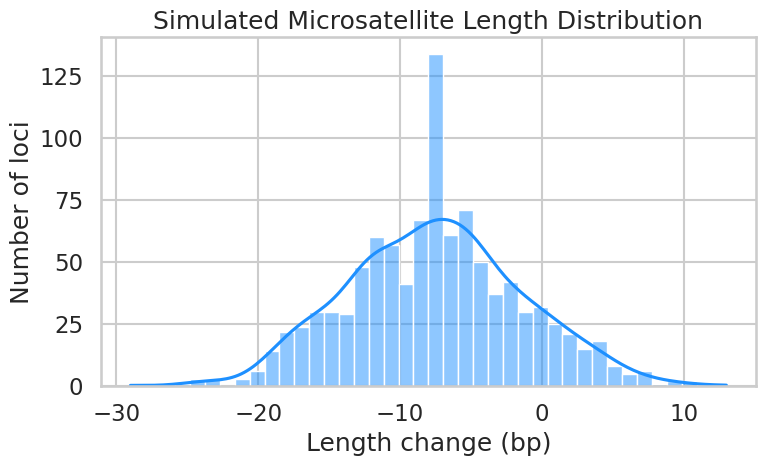

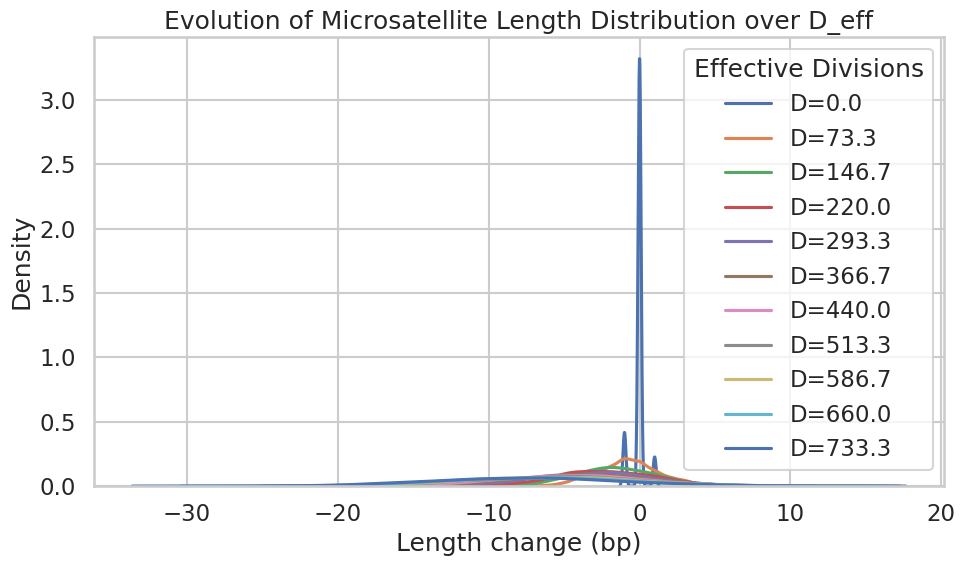

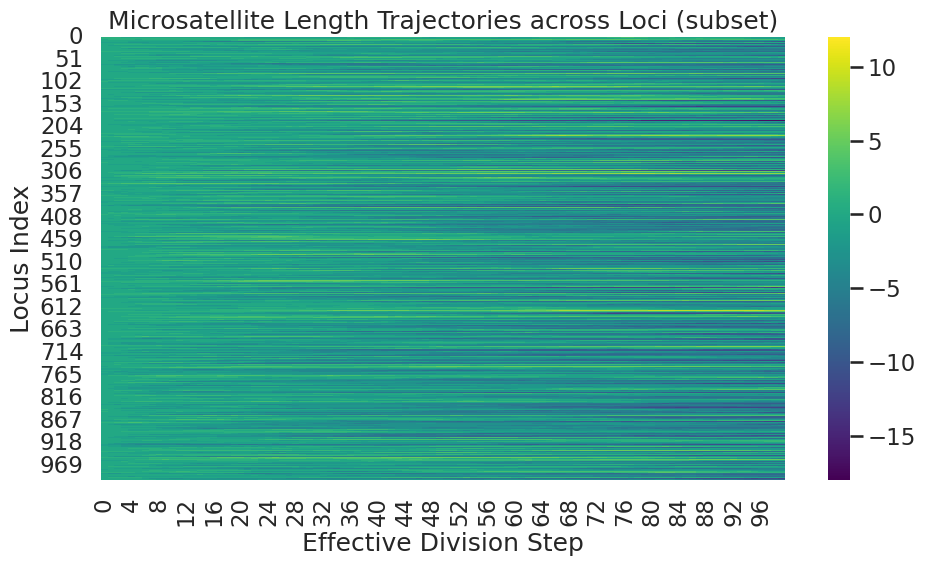

Gen 1: 100%|██████████| 300/300 [00:23<00:00, 12.67it/s]


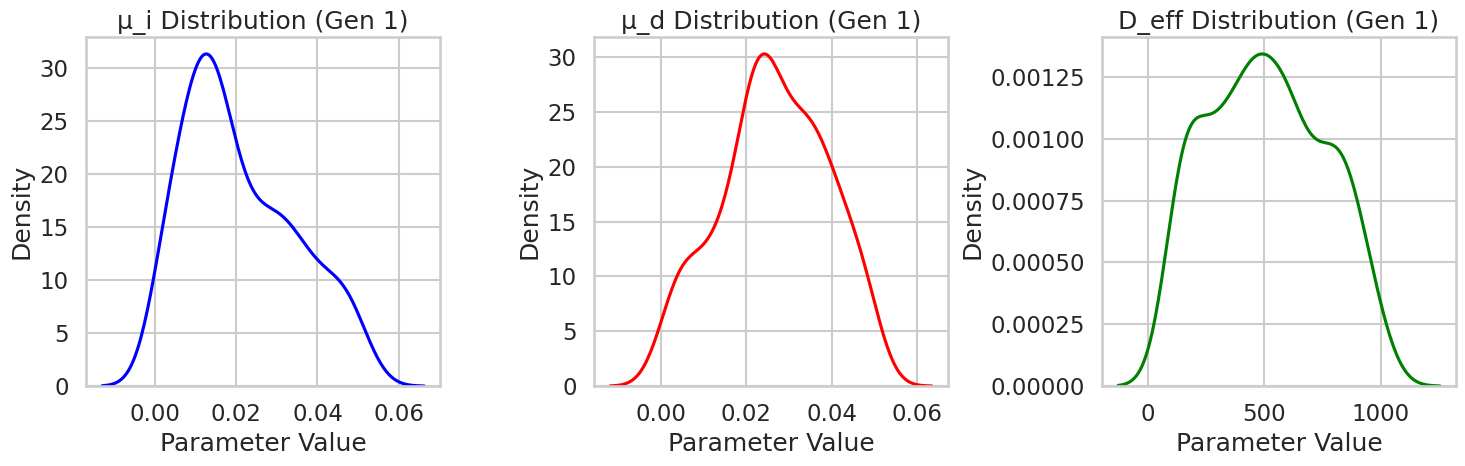

Gen 2: 100%|██████████| 300/300 [00:19<00:00, 15.40it/s]


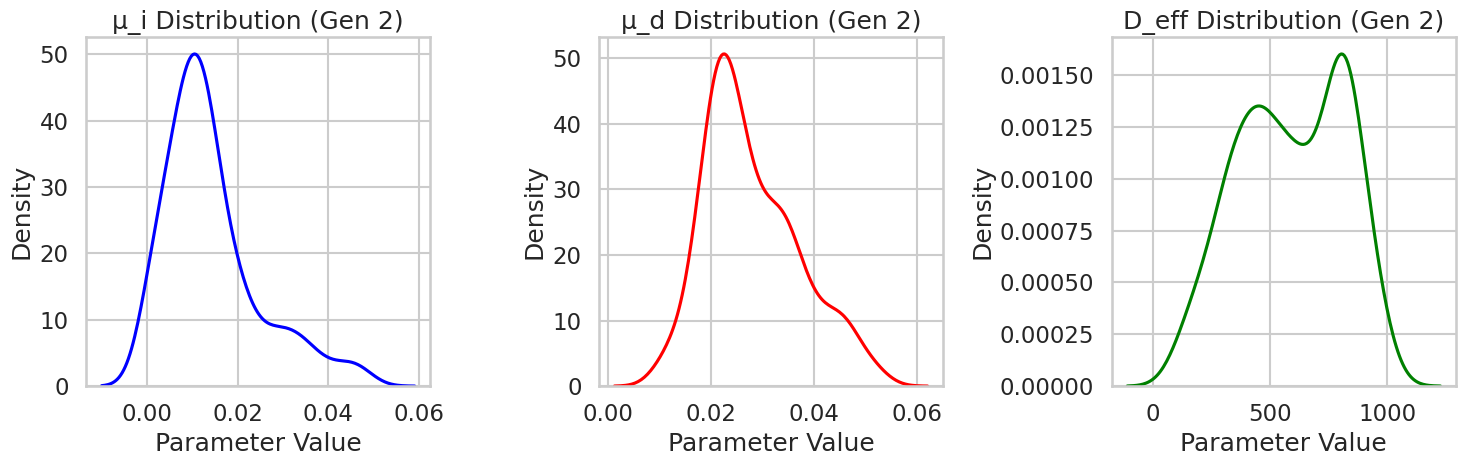

Gen 3: 100%|██████████| 300/300 [00:21<00:00, 14.08it/s]


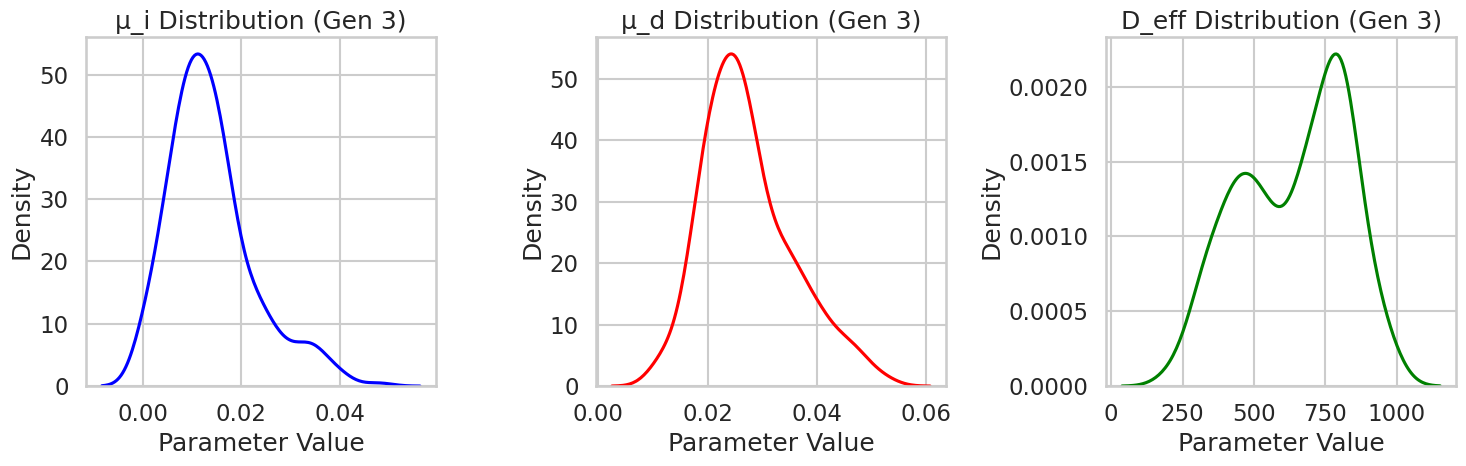

Gen 4: 100%|██████████| 300/300 [00:22<00:00, 13.24it/s]


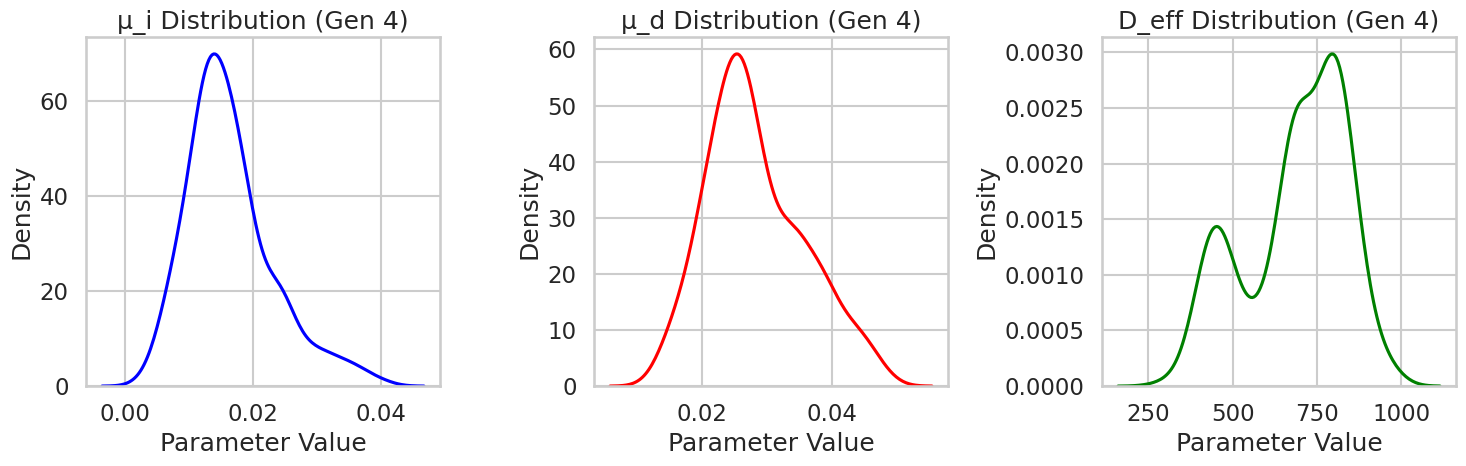

Gen 5: 100%|██████████| 300/300 [00:24<00:00, 12.10it/s]


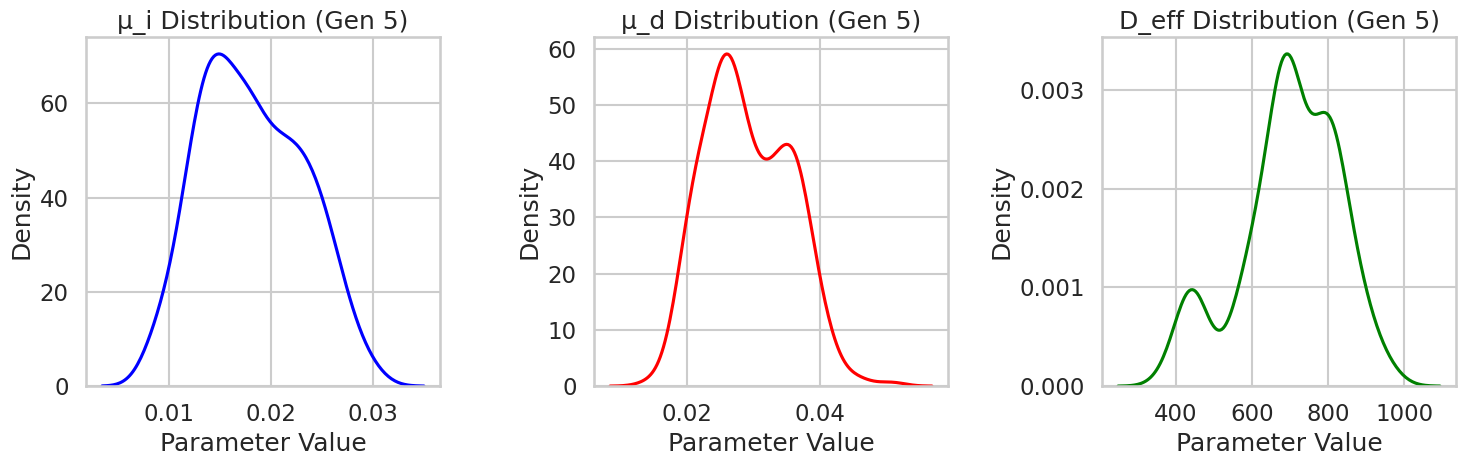

Gen 6: 100%|██████████| 300/300 [00:25<00:00, 11.66it/s]


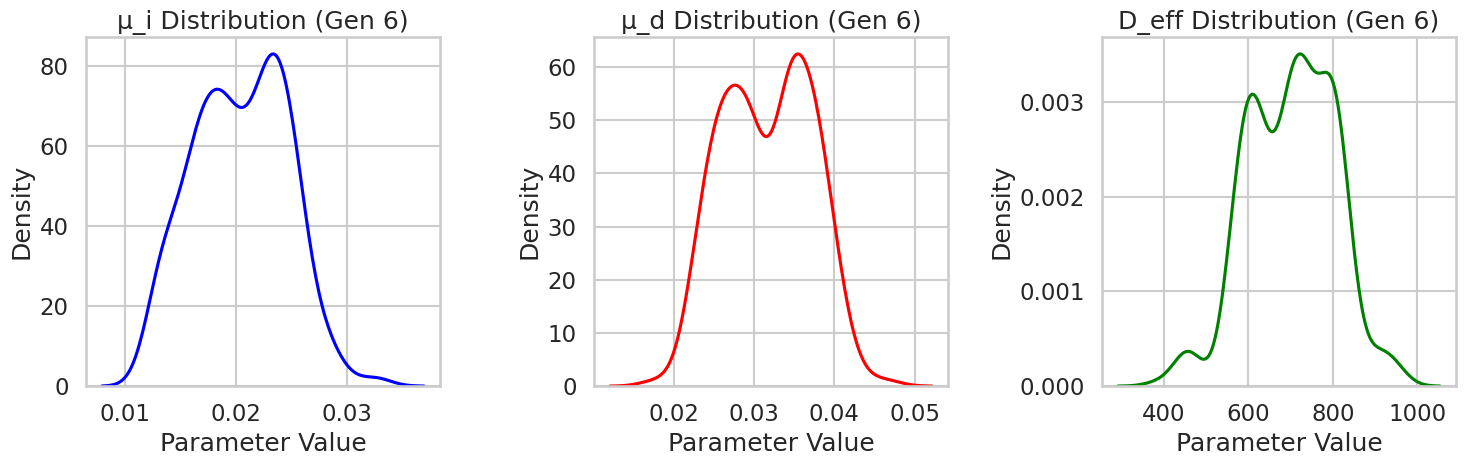


True: μ_i=0.02, μ_d=0.03, D_eff=750
Estimated: μ_i=0.0204, μ_d=0.0316, D_eff=701.62


In [ ]:
import torch
import numpy as np
from torch.distributions import Categorical, Uniform
from tqdm import tqdm
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

class MicrosatelliteEvoModel:
    """
    GPU-based stochastic Markov model of microsatellite evolution
    Inspired by EVOFLUX: evolving through indel transitions with effective divisions D_eff.
    """
    def __init__(self, num_loci=1000, mu_i=0.02, mu_d=0.03, D_eff=1000, device='cuda'):
        self.device = device
        self.num_loci = num_loci
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.D_eff = D_eff   # Effective total divisions (replaces r*T)

        # Initialize loci
        self.lengths = torch.zeros(num_loci, dtype=torch.int32, device=device)
        self.delta_div = 0.1 / max(mu_i, mu_d, 1e-6)
        self.p_insert = mu_i * self.delta_div
        self.p_delete = mu_d * self.delta_div
        self.p_stay = 1 - self.p_insert - self.p_delete

        # History for visualization
        self.history = []

    def stochastic_step(self):
        """Single Markov jump update for all loci."""
        probs = torch.tensor(
            [self.p_insert, self.p_delete, self.p_stay], device=self.device
        )
        transitions = Categorical(probs).sample((self.num_loci,))
        self.lengths += (transitions == 0).int() - (transitions == 1).int()

    def simulate(self, record_history=True):
        """Simulate stochastic microsatellite evolution up to D_eff divisions."""
        n_steps = int(self.D_eff / self.delta_div)
        for _ in range(n_steps):
            self.stochastic_step()
            if record_history:
                self.history.append(self.lengths.cpu().numpy().copy())
        return self.lengths.cpu().numpy()

    # === Visualization functions ===
    def plot_final_distribution(self, title="Final Microsatellite Length Distribution"):
        plt.figure(figsize=(8,5))
        sns.histplot(self.lengths.cpu().numpy(), bins=40, kde=True, color='dodgerblue')
        plt.title(title)
        plt.xlabel("Length change (bp)")
        plt.ylabel("Number of loci")
        plt.tight_layout()
        plt.show()

    def plot_evolution_heatmap(self):
        """Show evolution of distribution over effective divisions."""
        mat = np.stack(self.history)
        plt.figure(figsize=(10,6))
        sns.heatmap(mat[:100].T, cmap="viridis", cbar=True)
        plt.title("Microsatellite Length Trajectories across Loci (subset)")
        plt.xlabel("Effective Division Step")
        plt.ylabel("Locus Index")
        plt.tight_layout()
        plt.show()

    def plot_length_distribution_over_time(self):
        """Overlay histogram snapshots of evolving distribution."""
        n_frames = min(10, len(self.history))
        step = len(self.history)//n_frames
        plt.figure(figsize=(10,6))
        for i in range(0, len(self.history), step):
            sns.kdeplot(self.history[i], label=f"D={i*self.delta_div:.1f}")
        plt.title("Evolution of Microsatellite Length Distribution over D_eff")
        plt.xlabel("Length change (bp)")
        plt.ylabel("Density")
        plt.legend(title="Effective Divisions")
        plt.tight_layout()
        plt.show()

class ABCDeffInferencer:
    """
    Approximate Bayesian Computation - Sequential Monte Carlo inference
    Extended to infer D_eff together with μ_i, μ_d.
    """
    def __init__(self, observed, prior_ranges, n_particles=500):
        self.observed = observed
        self.priors = {
            'mu_i': Uniform(*prior_ranges['mu_i']),
            'mu_d': Uniform(*prior_ranges['mu_d']),
            'D_eff': Uniform(*prior_ranges['D_eff'])
        }
        self.n_particles = n_particles
        self.posterior = []

    def wasserstein(self, sim):
        return wasserstein_distance(self.observed, sim)

    def initialize_particles(self):
        return [{
            'mu_i': self.priors['mu_i'].sample().item(),
            'mu_d': self.priors['mu_d'].sample().item(),
            'D_eff': self.priors['D_eff'].sample().item()
        } for _ in range(self.n_particles)]

    def run(self, n_iter=10, eps_decay=0.9):
        particles = self.initialize_particles()
        eps = np.inf

        for gen in range(n_iter):
            valid, distances = [], []
            for p in tqdm(particles, desc=f"Gen {gen+1}"):
                try:
                    model = MicrosatelliteEvoModel(num_loci=1000,
                        mu_i=p['mu_i'], mu_d=p['mu_d'], D_eff=p['D_eff'])
                    sim = model.simulate(record_history=False)
                    d = self.wasserstein(sim)
                    if d < eps:
                        valid.append(p)
                        distances.append(d)
                except:
                    continue

            if len(valid) < 10:
                eps *= 1.2
                continue

            eps = np.percentile(distances, 50) * eps_decay
            weights = np.exp(-np.array(distances) / eps)
            weights /= weights.sum()

            idx = np.random.choice(range(len(valid)), self.n_particles, p=weights)
            new_particles = [valid[i].copy() for i in idx]

            # Gaussian jitter
            for p in new_particles:
                p['mu_i'] = max(1e-4, p['mu_i'] + np.random.normal(0, 0.002))
                p['mu_d'] = max(1e-4, p['mu_d'] + np.random.normal(0, 0.002))
                p['D_eff'] = max(50, p['D_eff'] + np.random.normal(0, 10))

            particles = new_particles
            self.posterior = particles.copy()
            self.plot_posterior(gen)

        return particles

    def plot_posterior(self, generation):
        mu_i_vals = [p['mu_i'] for p in self.posterior]
        mu_d_vals = [p['mu_d'] for p in self.posterior]
        D_vals = [p['D_eff'] for p in self.posterior]

        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        sns.kdeplot(mu_i_vals, ax=axes[0], color='blue')
        axes[0].set_title(f"μ_i Distribution (Gen {generation+1})")

        sns.kdeplot(mu_d_vals, ax=axes[1], color='red')
        axes[1].set_title(f"μ_d Distribution (Gen {generation+1})")

        sns.kdeplot(D_vals, ax=axes[2], color='green')
        axes[2].set_title(f"D_eff Distribution (Gen {generation+1})")

        for a in axes:
            a.set_xlabel("Parameter Value")
            a.set_ylabel("Density")
        plt.tight_layout()
        plt.show()

# ===== Example usage =====
if __name__ == "__main__":
    # Simulate synthetic data with known parameters
    true_params = {'mu_i': 0.02, 'mu_d': 0.03, 'D_eff': 750}
    model = MicrosatelliteEvoModel(**true_params)
    observed_data = model.simulate(record_history=True)

    # Visualizations for demonstration
    model.plot_final_distribution("Simulated Microsatellite Length Distribution")
    model.plot_length_distribution_over_time()
    model.plot_evolution_heatmap()

    # Set priors
    priors = {
        'mu_i': (0.001, 0.05),
        'mu_d': (0.001, 0.05),
        'D_eff': (100, 1000)
    }

    infer = ABCDeffInferencer(observed_data, priors, n_particles=300)
    results = infer.run(n_iter=6)

    # Final posterior summary
    mu_i_est = np.mean([p['mu_i'] for p in results])
    mu_d_est = np.mean([p['mu_d'] for p in results])
    Deff_est = np.mean([p['D_eff'] for p in results])
    print(f"\nTrue: μ_i={true_params['mu_i']}, μ_d={true_params['mu_d']}, D_eff={true_params['D_eff']}")
    print(f"Estimated: μ_i={mu_i_est:.4f}, μ_d={mu_d_est:.4f}, D_eff={Deff_est:.2f}")


Generating synthetic data with dynamic evolution...
Observed data: 1000 loci
Length range: [-28.0, 17.0]
Mean length change: -8.153
Std length change: 7.036


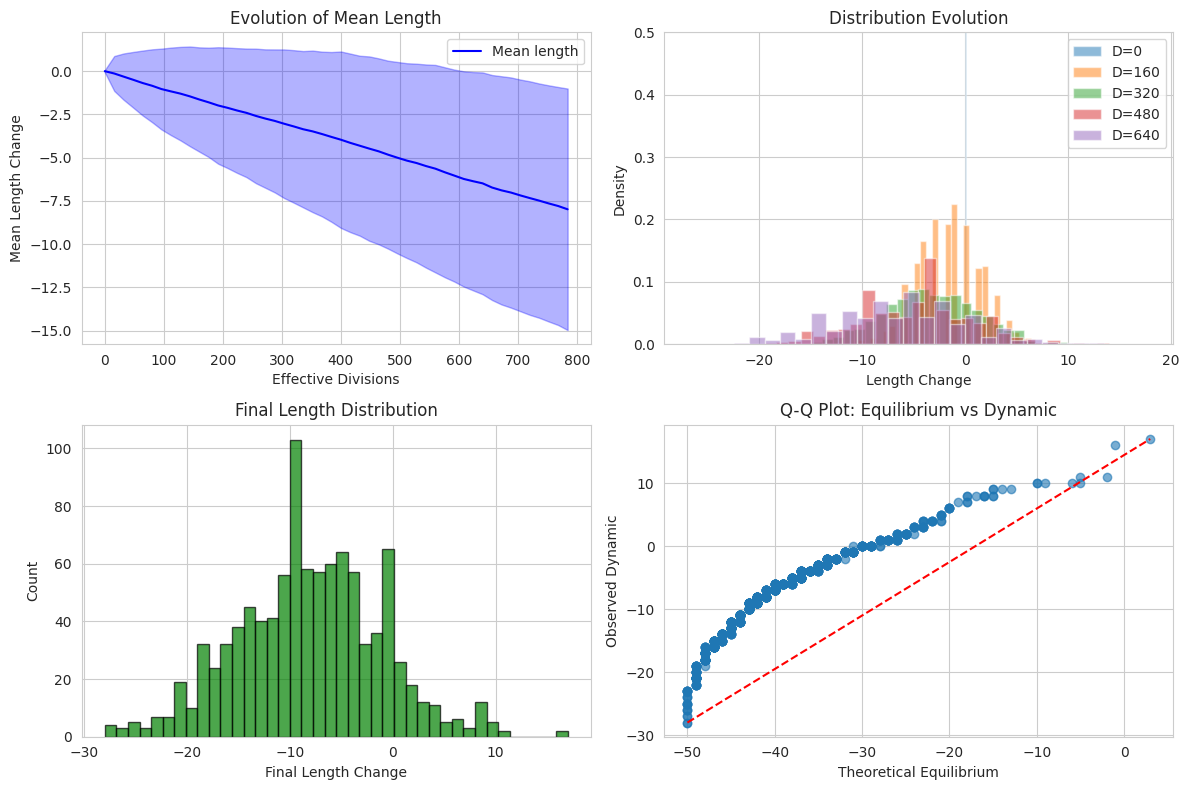


Running comparative inference...
Running equilibrium inference...


Equilibrium Iter 1: 100%|██████████| 200/200 [00:07<00:00, 25.56it/s]


Equilibrium Iter 1: ε=33.8494, n_valid=200


Equilibrium Iter 2: 100%|██████████| 200/200 [00:02<00:00, 99.56it/s] 


Equilibrium Iter 2: ε=19.2375, n_valid=93


Equilibrium Iter 3: 100%|██████████| 200/200 [00:01<00:00, 106.58it/s]


Equilibrium Iter 3: ε=12.8799, n_valid=110


Equilibrium Iter 4: 100%|██████████| 200/200 [00:01<00:00, 100.20it/s]


Equilibrium Iter 4: ε=11.2541, n_valid=40


Equilibrium Iter 6: 100%|██████████| 200/200 [00:01<00:00, 127.47it/s]


Equilibrium Iter 6: ε=11.2959, n_valid=106


Equilibrium Iter 8: 100%|██████████| 200/200 [00:02<00:00, 68.17it/s]


Equilibrium Iter 8: ε=11.4408, n_valid=122

Running dynamic inference...


Dynamic Iter 1: 100%|██████████| 200/200 [04:06<00:00,  1.23s/it]


Dynamic Iter 1: ε=8.8781, n_valid=200


Dynamic Iter 2: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Dynamic Iter 2: ε=3.9726, n_valid=154


Dynamic Iter 3: 100%|██████████| 200/200 [04:12<00:00,  1.26s/it]


Dynamic Iter 3: ε=2.0934, n_valid=135


Dynamic Iter 4: 100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


Dynamic Iter 4: ε=1.3617, n_valid=98


Dynamic Iter 5: 100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


Dynamic Iter 5: ε=0.8204, n_valid=72


Dynamic Iter 6: 100%|██████████| 200/200 [04:39<00:00,  1.40s/it]


Dynamic Iter 6: ε=0.5382, n_valid=63


Dynamic Iter 7: 100%|██████████| 200/200 [04:51<00:00,  1.46s/it]


Dynamic Iter 7: ε=0.3605, n_valid=30


Dynamic Iter 8: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]


Dynamic Iter 8: ε=0.3096, n_valid=15

Comparing approaches...


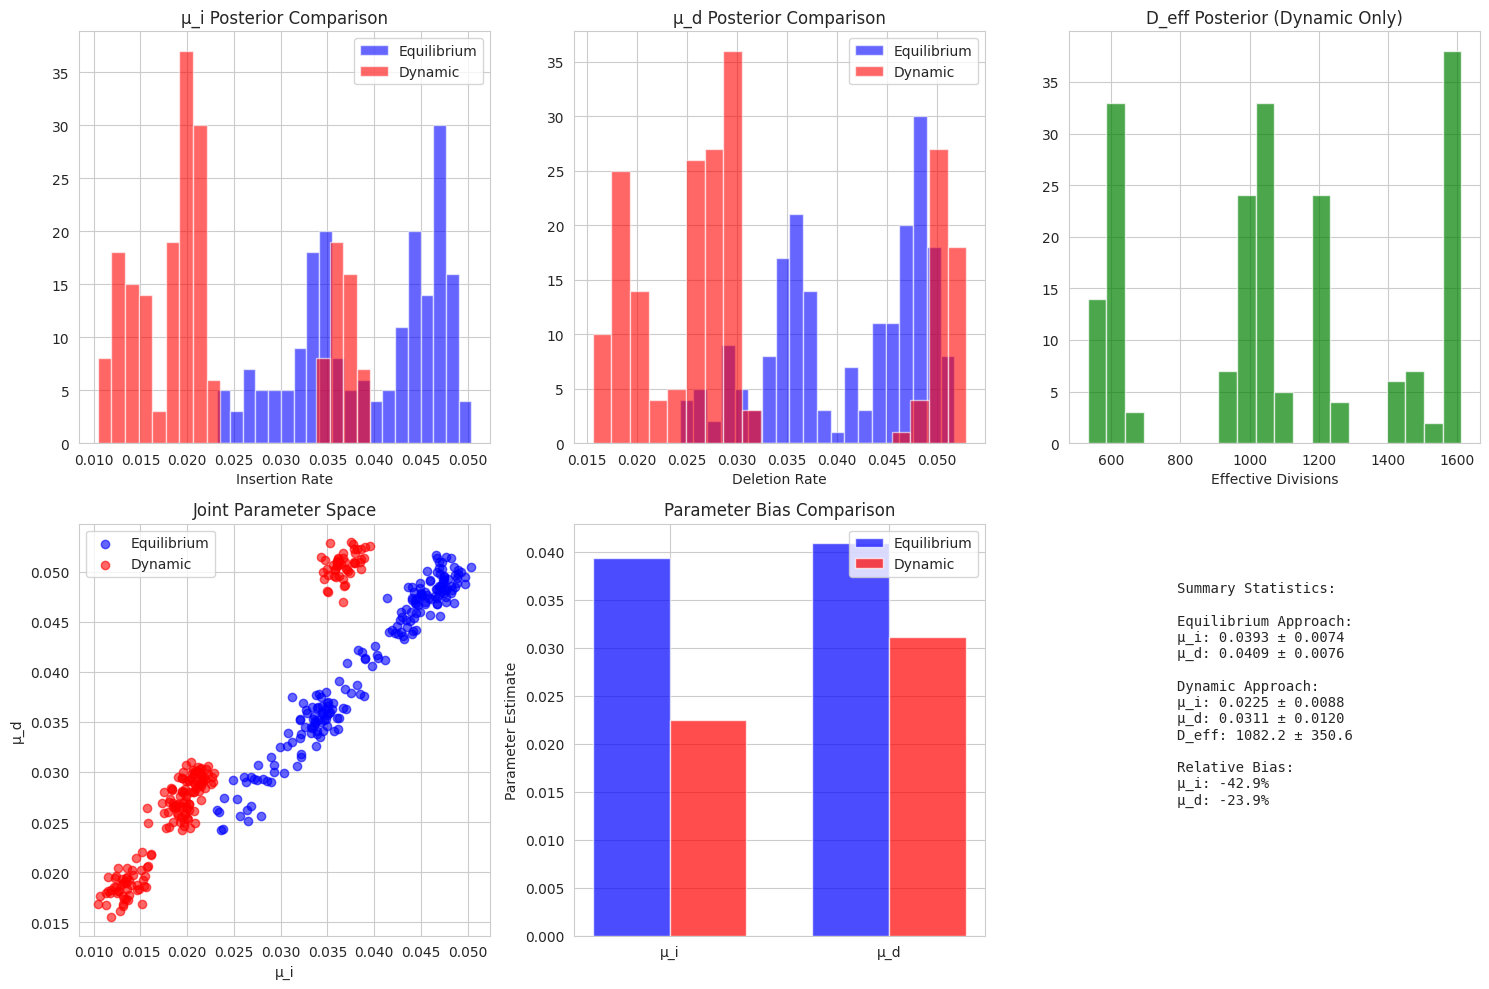


True parameters: μ_i=0.025, μ_d=0.035, D_eff=800
Inference comparison complete!


In [ ]:
import torch
import numpy as np
from torch.distributions import Categorical, Uniform, Normal
from scipy.stats import wasserstein_distance
from scipy.special import factorial
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

class EquilibriumMicrosatelliteModel:
    """
    Population genetics equilibrium model - assumes stationary distribution
    Based on Kruglyak et al. 1998 equilibrium theory
    """
    def __init__(self, mu_i=0.02, mu_d=0.03, max_length=50, device=None):
        self.device = device
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.max_length = max_length

        # Compute stationary distribution analytically
        self.stationary_probs = self._compute_stationary_distribution()

    def _compute_stationary_distribution(self):
        """
        Analytical stationary distribution for birth-death process
        π_k = π_0 * ∏(i=0 to k-1) [μ_i(i) / μ_d(i+1)]
        For constant rates: π_k ∝ (μ_i/μ_d)^k
        """
        # Transition matrix approach for finite state space
        n_states = 2 * self.max_length + 1  # [-max_length, +max_length]
        Q = torch.zeros(n_states, n_states, device=self.device)

        for i in range(n_states):
            length = i - self.max_length  # Convert index to length

            # Insertion (i -> i+1)
            if i < n_states - 1:
                Q[i, i+1] = self.mu_i

            # Deletion (i -> i-1)
            if i > 0:
                Q[i, i-1] = self.mu_d

            # Diagonal (staying in same state)
            Q[i, i] = -(self.mu_i + self.mu_d)

        # Find stationary distribution: π Q = 0
        # Equivalent to finding left eigenvector of Q with eigenvalue 0
        try:
            eigenvals, eigenvecs = torch.linalg.eig(Q.T)
            # Find eigenvector corresponding to eigenvalue closest to 0
            zero_idx = torch.argmin(torch.abs(eigenvals))
            stationary = torch.real(eigenvecs[:, zero_idx])
            stationary = torch.abs(stationary) / torch.sum(torch.abs(stationary))
            return stationary
        except:
            # Fallback: geometric distribution approximation
            ratio = self.mu_i / (self.mu_i + self.mu_d)
            probs = torch.zeros(n_states)
            center = n_states // 2
            for i in range(n_states):
                k = abs(i - center)
                probs[i] = (1 - ratio) * (ratio ** k)
            return probs / torch.sum(probs)

    def sample_equilibrium(self, n_loci=1000):
        """Sample from theoretical equilibrium distribution"""
        indices = torch.multinomial(self.stationary_probs, n_loci, replacement=True)
        lengths = indices - self.max_length  # Convert back to length space
        return lengths.float()

    def equilibrium_likelihood(self, observed_lengths):
        """Compute likelihood under equilibrium assumption"""
        # Discretize observed lengths and compute empirical distribution
        min_len, max_len = int(observed_lengths.min()), int(observed_lengths.max())
        empirical_counts = torch.zeros(max_len - min_len + 1)

        for i, length in enumerate(range(min_len, max_len + 1)):
            empirical_counts[i] = torch.sum(observed_lengths == length)

        empirical_probs = empirical_counts / torch.sum(empirical_counts)

        # Map to stationary distribution
        center = len(self.stationary_probs) // 2
        theoretical_probs = torch.zeros_like(empirical_probs)

        for i, length in enumerate(range(min_len, max_len + 1)):
            if abs(length) <= self.max_length:
                idx = length + center
                theoretical_probs[i] = self.stationary_probs[idx]

        theoretical_probs = theoretical_probs / torch.sum(theoretical_probs)

        # Compute log-likelihood
        log_likelihood = torch.sum(empirical_counts * torch.log(theoretical_probs + 1e-10))
        return log_likelihood.item()

class DynamicMicrosatelliteModel:
    """
    Dynamic model accounting for exponential growth and transient evolution
    """
    def __init__(self, num_loci=1000, mu_i=0.02, mu_d=0.03, D_eff=1000, device=None):
        self.device = device
        self.num_loci = num_loci
        self.mu_i = mu_i
        self.mu_d = mu_d
        self.D_eff = D_eff

        # Initialize
        self.lengths = torch.zeros(num_loci, dtype=torch.int32, device=device)
        self.delta_div = min(0.1, 1.0 / max(mu_i, mu_d, 1e-6))
        self.p_insert = mu_i * self.delta_div
        self.p_delete = mu_d * self.delta_div
        self.p_stay = 1 - self.p_insert - self.p_delete

        # Track evolution history
        self.length_history = []
        self.time_points = []

    def simulate(self, record_history=True):
        """Simulate dynamic evolution"""
        n_steps = max(1, int(self.D_eff / self.delta_div))

        for step in range(n_steps):
            # Stochastic mutations
            probs = torch.tensor([self.p_insert, self.p_delete, self.p_stay],
                               device=self.device)
            mutations = Categorical(probs).sample((self.num_loci,))

            # Update lengths
            self.lengths += (mutations == 0).int() - (mutations == 1).int()

            # Record history
            if record_history and step % max(1, n_steps // 50) == 0:
                self.length_history.append(self.lengths.clone().cpu().numpy())
                self.time_points.append(step * self.delta_div)

        return self.lengths.float().cpu().numpy()

class EquilibriumVsDynamicInference:
    """
    Compare equilibrium vs dynamic inference approaches
    """
    def __init__(self, observed_data, prior_ranges, n_particles=300):
        self.observed = observed_data
        self.priors = {
            'mu_i': Uniform(*prior_ranges['mu_i']),
            'mu_d': Uniform(*prior_ranges['mu_d']),
            'D_eff': Uniform(*prior_ranges['D_eff']) if 'D_eff' in prior_ranges else None
        }
        self.n_particles = n_particles
        self.equilibrium_results = None
        self.dynamic_results = None

    def equilibrium_inference(self, n_iter=10, verbose=True):
        """ABC inference assuming equilibrium"""
        particles = []
        for _ in range(self.n_particles):
            particles.append({
                'mu_i': self.priors['mu_i'].sample().item(),
                'mu_d': self.priors['mu_d'].sample().item()
            })

        eps = np.inf

        for iteration in range(n_iter):
            valid, distances = [], []

            for p in tqdm(particles, desc=f"Equilibrium Iter {iteration+1}"):
                try:
                    model = EquilibriumMicrosatelliteModel(
                        mu_i=p['mu_i'], mu_d=p['mu_d'])
                    sim_data = model.sample_equilibrium(len(self.observed)).cpu().numpy()
                    distance = wasserstein_distance(self.observed, sim_data)

                    if distance < eps:
                        valid.append(p)
                        distances.append(distance)
                except:
                    continue

            if len(valid) < 10:
                eps *= 1.2
                continue

            # Update threshold and resample
            eps = np.percentile(distances, 50) * 0.9
            weights = np.exp(-np.array(distances) / eps)
            weights /= weights.sum()

            idx = np.random.choice(len(valid), self.n_particles, p=weights)
            particles = [valid[i].copy() for i in idx]

            # Add noise
            for p in particles:
                p['mu_i'] = max(1e-4, p['mu_i'] + np.random.normal(0, 0.001))
                p['mu_d'] = max(1e-4, p['mu_d'] + np.random.normal(0, 0.001))

            if verbose:
                print(f"Equilibrium Iter {iteration+1}: ε={eps:.4f}, n_valid={len(valid)}")

        self.equilibrium_results = particles
        return particles

    def dynamic_inference(self, n_iter=10, verbose=True):
        """ABC inference with dynamic model"""
        particles = []
        for _ in range(self.n_particles):
            particles.append({
                'mu_i': self.priors['mu_i'].sample().item(),
                'mu_d': self.priors['mu_d'].sample().item(),
                'D_eff': self.priors['D_eff'].sample().item() if self.priors['D_eff'] else 1000
            })

        eps = np.inf

        for iteration in range(n_iter):
            valid, distances = [], []

            for p in tqdm(particles, desc=f"Dynamic Iter {iteration+1}"):
                try:
                    model = DynamicMicrosatelliteModel(
                        num_loci=len(self.observed),
                        mu_i=p['mu_i'], mu_d=p['mu_d'], D_eff=p['D_eff'])
                    sim_data = model.simulate(record_history=False)
                    distance = wasserstein_distance(self.observed, sim_data)

                    if distance < eps:
                        valid.append(p)
                        distances.append(distance)
                except:
                    continue

            if len(valid) < 10:
                eps *= 1.2
                continue

            # Update threshold and resample
            eps = np.percentile(distances, 50) * 0.9
            weights = np.exp(-np.array(distances) / eps)
            weights /= weights.sum()

            idx = np.random.choice(len(valid), self.n_particles, p=weights)
            particles = [valid[i].copy() for i in idx]

            # Add noise
            for p in particles:
                p['mu_i'] = max(1e-4, p['mu_i'] + np.random.normal(0, 0.001))
                p['mu_d'] = max(1e-4, p['mu_d'] + np.random.normal(0, 0.001))
                if 'D_eff' in p:
                    p['D_eff'] = max(50, p['D_eff'] + np.random.normal(0, 20))

            if verbose:
                print(f"Dynamic Iter {iteration+1}: ε={eps:.4f}, n_valid={len(valid)}")

        self.dynamic_results = particles
        return particles

    def compare_approaches(self):
        """Compare equilibrium vs dynamic inference results"""
        if not self.equilibrium_results or not self.dynamic_results:
            print("Run both inference methods first!")
            return

        # Extract parameter estimates
        eq_mu_i = [p['mu_i'] for p in self.equilibrium_results]
        eq_mu_d = [p['mu_d'] for p in self.equilibrium_results]

        dyn_mu_i = [p['mu_i'] for p in self.dynamic_results]
        dyn_mu_d = [p['mu_d'] for p in self.dynamic_results]
        dyn_D_eff = [p.get('D_eff', 1000) for p in self.dynamic_results]

        # Create comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # μ_i comparison
        axes[0,0].hist(eq_mu_i, alpha=0.6, bins=20, label='Equilibrium', color='blue')
        axes[0,0].hist(dyn_mu_i, alpha=0.6, bins=20, label='Dynamic', color='red')
        axes[0,0].set_title('μ_i Posterior Comparison')
        axes[0,0].set_xlabel('Insertion Rate')
        axes[0,0].legend()

        # μ_d comparison
        axes[0,1].hist(eq_mu_d, alpha=0.6, bins=20, label='Equilibrium', color='blue')
        axes[0,1].hist(dyn_mu_d, alpha=0.6, bins=20, label='Dynamic', color='red')
        axes[0,1].set_title('μ_d Posterior Comparison')
        axes[0,1].set_xlabel('Deletion Rate')
        axes[0,1].legend()

        # D_eff (only for dynamic)
        axes[0,2].hist(dyn_D_eff, bins=20, color='green', alpha=0.7)
        axes[0,2].set_title('D_eff Posterior (Dynamic Only)')
        axes[0,2].set_xlabel('Effective Divisions')

        # Joint parameter spaces
        axes[1,0].scatter(eq_mu_i, eq_mu_d, alpha=0.6, label='Equilibrium', color='blue')
        axes[1,0].scatter(dyn_mu_i, dyn_mu_d, alpha=0.6, label='Dynamic', color='red')
        axes[1,0].set_xlabel('μ_i')
        axes[1,0].set_ylabel('μ_d')
        axes[1,0].set_title('Joint Parameter Space')
        axes[1,0].legend()

        # Parameter bias comparison
        bias_data = {
            'Parameter': ['μ_i', 'μ_i', 'μ_d', 'μ_d'],
            'Method': ['Equilibrium', 'Dynamic', 'Equilibrium', 'Dynamic'],
            'Mean': [np.mean(eq_mu_i), np.mean(dyn_mu_i),
                    np.mean(eq_mu_d), np.mean(dyn_mu_d)],
            'Std': [np.std(eq_mu_i), np.std(dyn_mu_i),
                   np.std(eq_mu_d), np.std(dyn_mu_d)]
        }

        x = np.arange(2)
        width = 0.35
        axes[1,1].bar(x - width/2, [np.mean(eq_mu_i), np.mean(eq_mu_d)],
                     width, label='Equilibrium', color='blue', alpha=0.7)
        axes[1,1].bar(x + width/2, [np.mean(dyn_mu_i), np.mean(dyn_mu_d)],
                     width, label='Dynamic', color='red', alpha=0.7)
        axes[1,1].set_ylabel('Parameter Estimate')
        axes[1,1].set_title('Parameter Bias Comparison')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(['μ_i', 'μ_d'])
        axes[1,1].legend()

        # Summary statistics
        axes[1,2].axis('off')
        summary_text = f"""
        Summary Statistics:

        Equilibrium Approach:
        μ_i: {np.mean(eq_mu_i):.4f} ± {np.std(eq_mu_i):.4f}
        μ_d: {np.mean(eq_mu_d):.4f} ± {np.std(eq_mu_d):.4f}

        Dynamic Approach:
        μ_i: {np.mean(dyn_mu_i):.4f} ± {np.std(dyn_mu_i):.4f}
        μ_d: {np.mean(dyn_mu_d):.4f} ± {np.std(dyn_mu_d):.4f}
        D_eff: {np.mean(dyn_D_eff):.1f} ± {np.std(dyn_D_eff):.1f}

        Relative Bias:
        μ_i: {((np.mean(dyn_mu_i) - np.mean(eq_mu_i))/np.mean(eq_mu_i)*100):.1f}%
        μ_d: {((np.mean(dyn_mu_d) - np.mean(eq_mu_d))/np.mean(eq_mu_d)*100):.1f}%
        """
        axes[1,2].text(0.1, 0.9, summary_text, transform=axes[1,2].transAxes,
                      fontsize=10, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.show()

        return bias_data

# Validation Example
if __name__ == "__main__":
    # Generate synthetic cancer evolution data (non-equilibrium)
    true_params = {'mu_i': 0.025, 'mu_d': 0.035, 'D_eff': 800}

    print("Generating synthetic data with dynamic evolution...")
    dynamic_model = DynamicMicrosatelliteModel(num_loci=1000, **true_params)
    observed_data = dynamic_model.simulate(record_history=True)

    print(f"Observed data: {len(observed_data)} loci")
    print(f"Length range: [{observed_data.min():.1f}, {observed_data.max():.1f}]")
    print(f"Mean length change: {observed_data.mean():.3f}")
    print(f"Std length change: {observed_data.std():.3f}")

    # Plot evolution history
    plt.figure(figsize=(12, 8))
    history = np.array(dynamic_model.length_history)
    times = np.array(dynamic_model.time_points)

    # Show evolution of mean and variance
    plt.subplot(2,2,1)
    means = np.mean(history, axis=1)
    stds = np.std(history, axis=1)
    plt.plot(times, means, 'b-', label='Mean length')
    plt.fill_between(times, means-stds, means+stds, alpha=0.3, color='blue')
    plt.xlabel('Effective Divisions')
    plt.ylabel('Mean Length Change')
    plt.title('Evolution of Mean Length')
    plt.legend()

    # Show distribution evolution
    plt.subplot(2,2,2)
    for i in range(0, len(history), len(history)//5):
        plt.hist(history[i], bins=30, alpha=0.5,
                label=f'D={times[i]:.0f}', density=True)
    plt.xlabel('Length Change')
    plt.ylabel('Density')
    plt.ylim(0,0.5)
    plt.title('Distribution Evolution')
    plt.legend()

    # Final distribution
    plt.subplot(2,2,3)
    plt.hist(observed_data, bins=40, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Final Length Change')
    plt.ylabel('Count')
    plt.title('Final Length Distribution')

    # QQ plot against theoretical equilibrium
    eq_model = EquilibriumMicrosatelliteModel(mu_i=true_params['mu_i'],
                                            mu_d=true_params['mu_d'])
    eq_sample = eq_model.sample_equilibrium(1000).cpu().numpy()

    plt.subplot(2,2,4)
    plt.scatter(np.sort(eq_sample), np.sort(observed_data), alpha=0.6)
    plt.plot([min(eq_sample), max(eq_sample)],
             [min(observed_data), max(observed_data)], 'r--')
    plt.xlabel('Theoretical Equilibrium')
    plt.ylabel('Observed Dynamic')
    plt.title('Q-Q Plot: Equilibrium vs Dynamic')

    plt.tight_layout()
    plt.show()

    # Run comparative inference
    print("\nRunning comparative inference...")
    prior_ranges = {
        'mu_i': (0.01, 0.05),
        'mu_d': (0.01, 0.05),
        'D_eff': (200, 1500)
    }

    comparator = EquilibriumVsDynamicInference(observed_data, prior_ranges, n_particles=200)

    print("Running equilibrium inference...")
    eq_results = comparator.equilibrium_inference(n_iter=8, verbose=True)

    print("\nRunning dynamic inference...")
    dyn_results = comparator.dynamic_inference(n_iter=8, verbose=True)

    print("\nComparing approaches...")
    bias_summary = comparator.compare_approaches()

    print(f"\nTrue parameters: μ_i={true_params['mu_i']}, μ_d={true_params['mu_d']}, D_eff={true_params['D_eff']}")
    print("Inference comparison complete!")
